# Homework #2 (Due 09/24/2020, 11:59pm)
## Bayesian versus Frequentist Inference

**AM 207: Advanced Scientific Computing**<br>
**Instructor: Weiwei Pan**<br>
**Fall 2020**

**Name:**

**Students collaborators:**

### Instructions:

**Submission Format:** Use this notebook as a template to complete your homework. Please intersperse text blocks (using Markdown cells) amongst `python` code and results -- format your submission for maximum readability. Your assignments will be graded for correctness as well as clarity of exposition and presentation -- a “right” answer by itself without an explanation or is presented with a difficult to follow format will receive no credit.

**Code Check:** Before submitting, you must do a "Restart and Run All" under "Kernel" in the Jupyter or colab menu. ***Portions of your submission that contains syntactic or run-time errors will not be graded***.

**Libraries and packages:** Unless a problems specifically asks you to implement from scratch, you are welcomed to use any `python` library package in the standard Anaconda distribution.

In [2]:
### Import basic libraries
import numpy as np
import pandas as pd
import sklearn as sk
from sklearn.metrics import mean_squared_error
from scipy.stats import multivariate_normal
from sklearn.linear_model import LinearRegression, Ridge, BayesianRidge
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def get_posterior_samples(prior_var, noise_var, x_matrix, y_matrix, x_test_matrix, samples=100):
    '''Function to generate posterior predictive samples for Bayesian linear regression model'''
    prior_variance = np.diag(prior_var * np.ones(x_matrix.shape[1]))
    prior_precision = np.linalg.inv(prior_variance)

    joint_precision = prior_precision + x_matrix.T.dot(x_matrix) / noise_var
    joint_variance = np.linalg.inv(joint_precision)
    joint_mean = joint_variance.dot(x_matrix.T.dot(y_matrix)) / noise_var

    #sampling 100 points from the posterior
    posterior_samples = np.random.multivariate_normal(joint_mean.flatten(), joint_variance, size=samples)

    #take posterior predictive samples
    posterior_predictions = np.dot(posterior_samples, x_test_matrix.T) 
    posterior_predictive_samples = posterior_predictions[np.newaxis, :, :] + np.random.normal(0, noise_var**0.5, size=(100, posterior_predictions.shape[0], posterior_predictions.shape[1]))
    posterior_predictive_samples = posterior_predictive_samples.reshape((100 * posterior_predictions.shape[0], posterior_predictions.shape[1]))
    return posterior_predictions, posterior_predictive_samples


def generate_data(number_of_points=10, noise_variance=0.3):
    '''Function for generating toy regression data'''
    #training x
    x_train = np.hstack((np.linspace(-1, -0.5, number_of_points), np.linspace(0.5, 1, number_of_points)))
    #function relating x and y
    f = lambda x: 3 * x**3
    #y is equal to f(x) plus gaussian noise
    y_train = f(x_train) + np.random.normal(0, noise_variance**0.5, 2 * number_of_points)
    x_test = np.array(list(set(list(np.hstack((np.linspace(-1, 1, 200), x_train))))))
    x_test = np.sort(x_test)
    y_test = f(x_test) + np.random.normal(0, noise_variance**0.5, size=x_test.shape)
    return x_train, y_train, x_test, y_test

## Part I: Maximum Likelihood Estimators for Polynomial Regression

In this problem, you are given a function, `generate_data`, to generate toy datasets with a single predictor $X$ and a single outcome $y$, and your task is to fit polynomial models to the data. That is, assume that the outcome $y$ can be modeled by the following process:

\begin{align}
y &= f(x) + \epsilon = w_0 + w_1x + w_2x^2 + \ldots + w_Dx^D + \epsilon, \quad \epsilon \sim \mathcal{N}(0, 0.3)
\end{align}

where the $w_d$, the *parameters* of the function $f$, are unknown constants, and the degree $D$ is a hyperparameter.


You'll notice that in these datasets, the test input is sampled from a different distribution that the training input: the training input has a gap, there are no training input values in [-0.5, 0.5], where as the test input are sampled across [-1, 1]. This change of the distributions over the $x$-values between training and test is called **covariate shift**.

These toy datasets simulate a very common problem in machine learning: models are fitted on training data, but during deployment they are given data dissimlar to the training data (i.e. the model encounters covariate shift). As such, you should treat `x_train`, `y_train` as data available during model development and evaluation, and `x_test`, `y_test` as data you collect during model deployment. 

The goal in this assignment is to explore how to manage the risk of a deployed model under covariate shift. The ideas developed in this assignment will become a major focus in the latter part of the course and the foundation of an active area of current research.

1. **(Effect of Model Complexity)** Generate a toy dataset with 40 observations (set the parameter `number_of_points=20` for `generate_data`, since twice the number of `number_of_points` will be generated), then  visualize the fit of MLE polynomial models, with degrees $D = [1, 3, 5, 10, 15, 20, 50, 100]$, on the training data (you should train on `x_train` and visualize by predicting on `x_test` provided by the data generating function; `x_test` is a larger set of test points that includes `x_train`). You'll need to be thoughtful about your visualization so that these different models can be visually compared in a meaningful way. <br><br>
Discuss the effect of the choice of polynomial degree on the fit of the model (concretely describe why certain choices are unideal in the context of the problem).

***My Answer Attempt.***

We need to fit a polynomial regression model that neither overfits or underfits the data. Especially in our situation (in which there is a covariate shift) between the training and testing distributions, a bad choice for the degree of polynomial we train with will not fit the data properly and thus harm our potential model deployment. Personally, by bootstrapping we can better see how the polynomial regression model fits over many samples. This process would help us ensure that if we were to deploy our model in the future, it would not present really bad predictions.

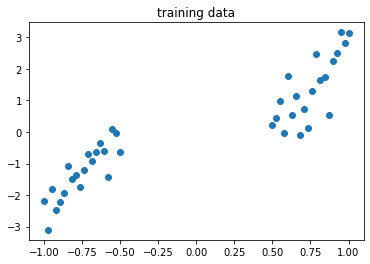

In [22]:
# Number of data points in each of the two segments of the domain
N = 20

# Observation noise variance
noise_variance = 0.3

# Generate toy data
x_train, y_train, x_test, y_test = generate_data(number_of_points=N, noise_variance=noise_variance)

# Plot the training data
plt.scatter(x_train, y_train)
plt.title('training data')
plt.show()

In [23]:
def makepolymodel(degree):
    # Make an instance of the PolynomialFeatures model to add polynomial powers to our covariates
    poly = PolynomialFeatures(degree)

    # Make an instance of the LinearRegression to perform regression
    linear_model = LinearRegression(fit_intercept=False)

    # Number of boostrap polyomial models to fit
    trials = 100
    # Make a list to record all model predictions
    y_test_poly = []

    # Bootstrap 100 training sets and fit a polynomial regression model on each
    for i in range(trials):

        if i % 10 == 0:
            print('bootstrap:', i)

        # Generate a bootstrap sample from the data
        indices = np.random.choice(np.arange(len(x_train)), size=len(x_train))
        bootstrap_x = x_train[indices]
        bootstrap_y = y_train[indices]

        # Fit a polynomial model
        bootstrap_x_poly = poly.fit_transform(bootstrap_x.reshape((-1, 1)))
        bootstrap_x_test_poly = poly.fit_transform(x_test.reshape((-1, 1)))
        linear_model.fit(bootstrap_x_poly, bootstrap_y)

        # Predict on x_test
        y_test = linear_model.predict(bootstrap_x_test_poly)
        y_test_poly.append(y_test)

    y_test_poly = np.array(y_test_poly)

    # Compute the 97.5 th percentile of the posterior predictive predictions
    y_test_poly_ub = np.percentile(y_test_poly, 97.5, axis=0)

    # Compute the 50 th percentile of the posterior predictive predictions
    y_test_poly_mean = np.percentile(y_test_poly, 50.0, axis=0)

    # Compute the 2.5 th percentile of the posterior predictive predictions
    y_test_poly_lb = np.percentile(y_test_poly, 2.5, axis=0)

    # Visualize these 100 boostrap models and visualize their 95% posterior predictive interval
    fig, ax = plt.subplots(1, 2, figsize=(20, 5))
    ax[0].scatter(x_train, y_train, color='black', label='data')
    ax[1].scatter(x_train, y_train, color='black', label='data')

    # Plot the 100 polynomial models; D=1
    for y_poly in y_test_poly:
        ax[0].plot(x_test, y_poly, color='blue', alpha=0.2)

    ax[0].set_ylim([-5, 5])
    ax[0].set_title('100 polynomial regression models; DEGREE '+str(degree).format(trials))

    # Plot 95% predictive interval
    ax[1].fill_between(x_test, y_test_poly_ub, y_test_poly_lb, color='blue', alpha=0.2)
    ax[1].plot(x_test, y_test_poly_mean, color='blue', alpha=0.9)

    ax[1].set_ylim([-5, 5])
    ax[1].set_title('95% prediction interval for {} polynomial regression models'.format(trials))

    plt.show()

bootstrap: 0
bootstrap: 10
bootstrap: 20
bootstrap: 30
bootstrap: 40
bootstrap: 50
bootstrap: 60
bootstrap: 70
bootstrap: 80
bootstrap: 90


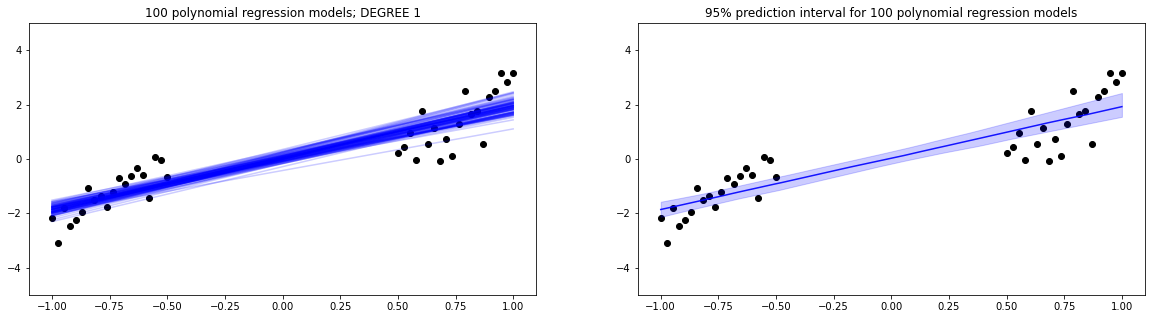

bootstrap: 0
bootstrap: 10
bootstrap: 20
bootstrap: 30
bootstrap: 40
bootstrap: 50
bootstrap: 60
bootstrap: 70
bootstrap: 80
bootstrap: 90


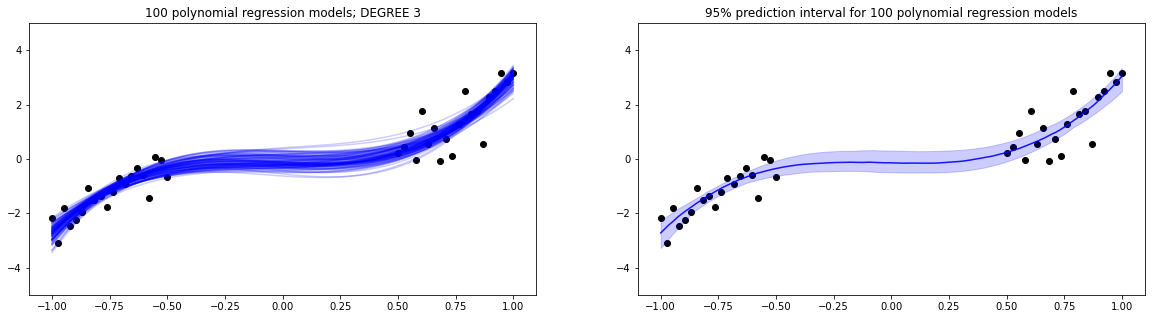

bootstrap: 0
bootstrap: 10
bootstrap: 20
bootstrap: 30
bootstrap: 40
bootstrap: 50
bootstrap: 60
bootstrap: 70
bootstrap: 80
bootstrap: 90


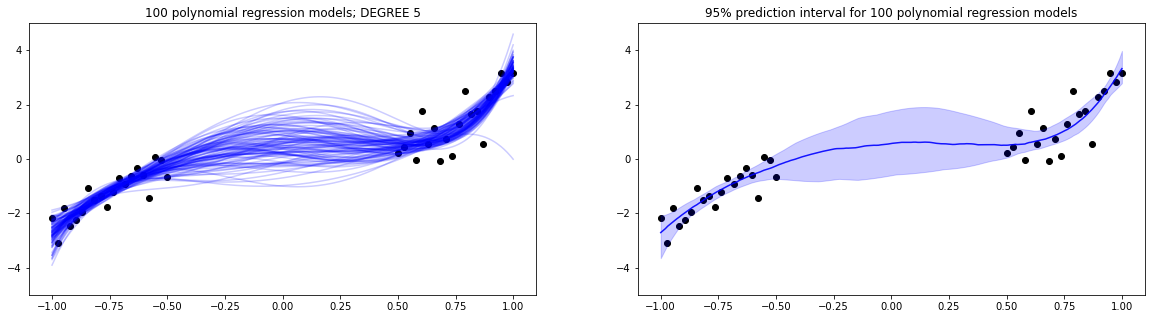

bootstrap: 0
bootstrap: 10
bootstrap: 20
bootstrap: 30
bootstrap: 40
bootstrap: 50
bootstrap: 60
bootstrap: 70
bootstrap: 80
bootstrap: 90


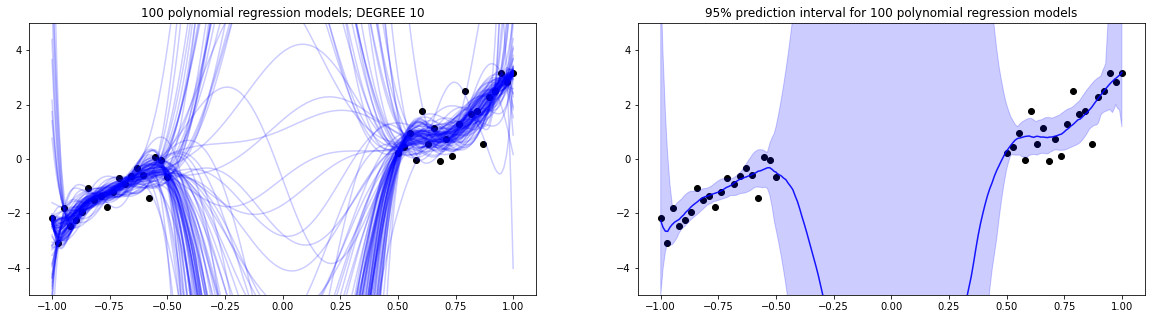

bootstrap: 0
bootstrap: 10
bootstrap: 20
bootstrap: 30
bootstrap: 40
bootstrap: 50
bootstrap: 60
bootstrap: 70
bootstrap: 80
bootstrap: 90


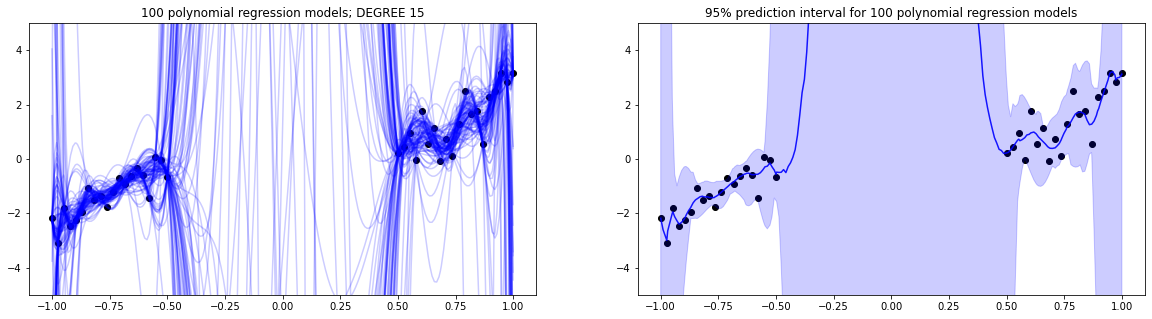

bootstrap: 0
bootstrap: 10
bootstrap: 20
bootstrap: 30
bootstrap: 40
bootstrap: 50
bootstrap: 60
bootstrap: 70
bootstrap: 80
bootstrap: 90


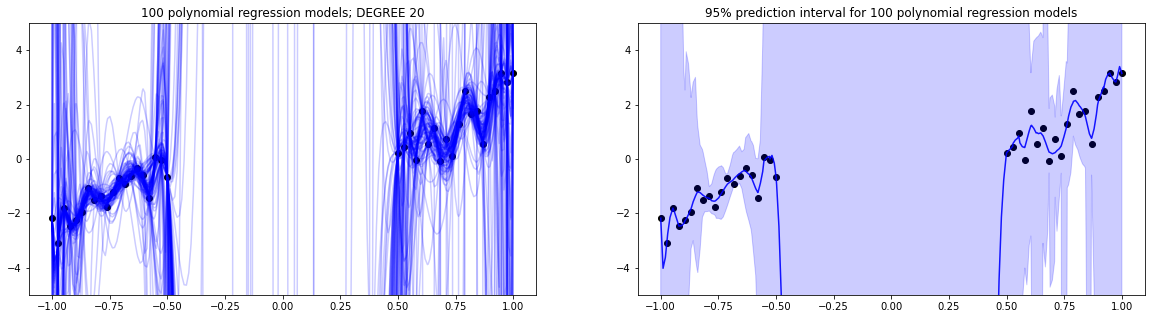

bootstrap: 0
bootstrap: 10
bootstrap: 20
bootstrap: 30
bootstrap: 40
bootstrap: 50
bootstrap: 60
bootstrap: 70
bootstrap: 80
bootstrap: 90


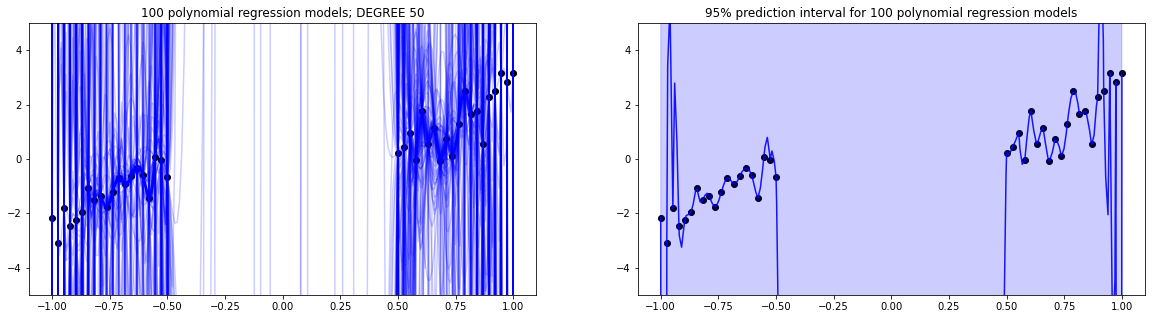

bootstrap: 0
bootstrap: 10
bootstrap: 20
bootstrap: 30
bootstrap: 40
bootstrap: 50
bootstrap: 60
bootstrap: 70
bootstrap: 80
bootstrap: 90


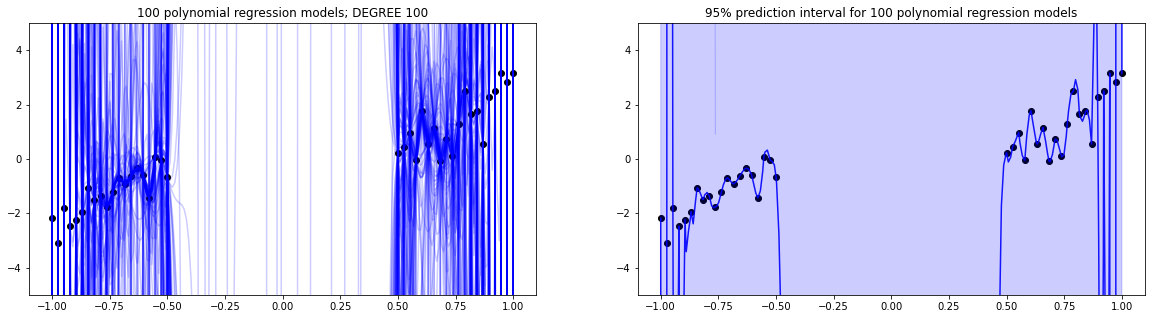

In [24]:
#Define Degrees of Interest
D = [1,3,5,10,15,20,50,100]

for i in D:
    makepolymodel(i)

2. **(Model Selection)** Later in the course, we will study a number of metrics commonly used for selecting between different MLE models. All of these metric essentially encode Occam's Razor: select the minimal complexity of model that satisfies some pre-determined modeling goal. <br><br>
For now, a very simple method for selecting the optimal degree is via cross-validation (by bootstrap):

  1. randomly sample two datasets, `x_train`, from the observed data: one for training and one for validation. Fit an MLE  polynomial model of degree $d$ on the training data and evaluate its performance on the validation data. Over $S$ number of such randomly sampled pairs of datasets, average the model's validation performance.
  2. plot the validation score as a function of model complexity, the polynomial degree $d$. 
  3. based on the plot, select the the minimal degree that achieves a high average validation performance (i.e. look for the 'elbow' of the plot).

  Explain why performing model selection by cross-validation mitigates the risk of choosing an undesirable polynomial (identified in Problem 1)?<br><br>
  Implement model selection by cross-validation for the toy dataset generated in Problem 1 using MSE as your performance metric and select an optimal degree from $D=[1,3,5,10,15,20,50,100]$.

***My Answer Attempt.***

I randomly sampled the data set twice and reported the MSE of each sampling before the plots with their respective degrees.

From observation of the MSE's, we can see that there is great differences in MSE simply by sampling. By purposefully choosing to select a certain part of the whole data set available and different which parts we choose, our model may fit quite different. Thus, by sampling using this model on the data set multiple times, we can mitigate our risk and ensure that MSE won't be too terrible if our model is ever in deployment. Looking at our statistical model in "two different" ways in the same data set does indeed help us cross-validate and further helps us decide which polynomial degree to choose.


In [32]:
def makepolymodel(degree=1):
    # Make an instance of the PolynomialFeatures model to add polynomial powers to our covariates
    poly = PolynomialFeatures(degree)

    # Make an instance of the LinearRegression to perform regression
    linear_model = LinearRegression(fit_intercept=False)

    # Number of boostrap polyomial models to fit
    trials = 2
    # Make a list to record all model predictions
    y_test_poly = []

    # Bootstrap 100 training sets and fit a polynomial regression model on each
    for i in range(trials):

        if i % 10 == 0:
            print('bootstrap:', i)

        # Generate a bootstrap sample from the data
        indices = np.random.choice(np.arange(len(x_train)), size=len(x_train))
        bootstrap_x = x_train[indices]
        bootstrap_y = y_train[indices]

        # Fit a polynomial model
        bootstrap_x_poly = poly.fit_transform(bootstrap_x.reshape((-1, 1)))
        bootstrap_x_test_poly = poly.fit_transform(x_test.reshape((-1, 1)))
        linear_model.fit(bootstrap_x_poly, bootstrap_y)

        # Predict on x_test
        y_test = linear_model.predict(bootstrap_x_test_poly)
        y_test_poly.append(y_test)
        
        #Find the MSE
        print("The Mean Squared Error of this bootstrapped poly regression model of degree ", degree, " is ", sk.metrics.mean_squared_error(x_test, y_test))

    y_test_poly = np.array(y_test_poly)

    # Compute the 97.5 th percentile of the posterior predictive predictions
    y_test_poly_ub = np.percentile(y_test_poly, 97.5, axis=0)

    # Compute the 50 th percentile of the posterior predictive predictions
    y_test_poly_mean = np.percentile(y_test_poly, 50.0, axis=0)

    # Compute the 2.5 th percentile of the posterior predictive predictions
    y_test_poly_lb = np.percentile(y_test_poly, 2.5, axis=0)

    # Visualize these 100 boostrap models and visualize their 95% posterior predictive interval
    fig, ax = plt.subplots(1, 2, figsize=(20, 5))
    ax[0].scatter(x_train, y_train, color='black', label='data')
    ax[1].scatter(x_train, y_train, color='black', label='data')

    # Plot the 100 polynomial models; D=1
    for y_poly in y_test_poly:
        ax[0].plot(x_test, y_poly, color='blue', alpha=0.2)

    ax[0].set_ylim([-5, 5])
    ax[0].set_title('100 polynomial regression models; DEGREE '+str(degree).format(trials))

    # Plot 95% predictive interval
    ax[1].fill_between(x_test, y_test_poly_ub, y_test_poly_lb, color='blue', alpha=0.2)
    ax[1].plot(x_test, y_test_poly_mean, color='blue', alpha=0.9)

    ax[1].set_ylim([-5, 5])
    ax[1].set_title('95% prediction interval for {} polynomial regression models'.format(trials))

    plt.show()


bootstrap: 0
The Mean Squared Error of this bootstrapped poly regression model of degree  1  is  0.5438576015776899
The Mean Squared Error of this bootstrapped poly regression model of degree  1  is  0.20689348514179298


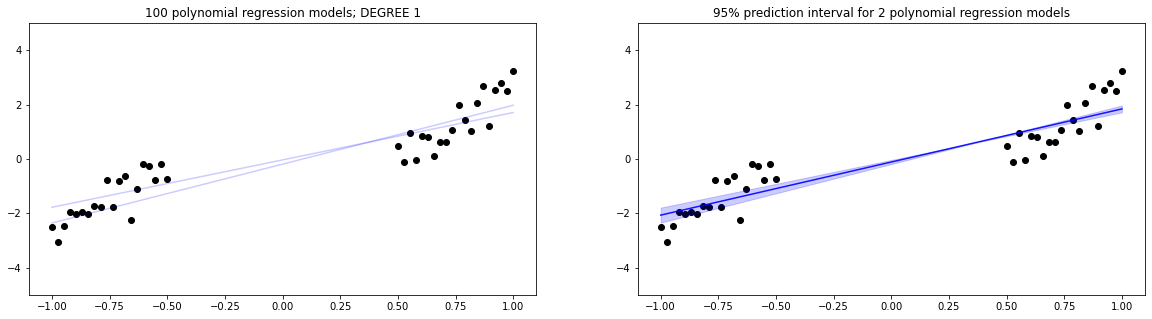

bootstrap: 0
The Mean Squared Error of this bootstrapped poly regression model of degree  3  is  0.5698459718584094
The Mean Squared Error of this bootstrapped poly regression model of degree  3  is  0.3762449285675639


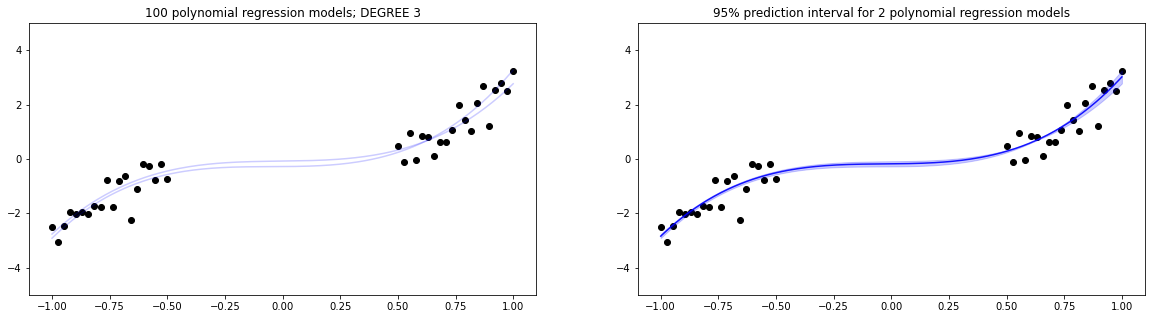

bootstrap: 0
The Mean Squared Error of this bootstrapped poly regression model of degree  5  is  0.5576480319087113
The Mean Squared Error of this bootstrapped poly regression model of degree  5  is  0.721097601829684


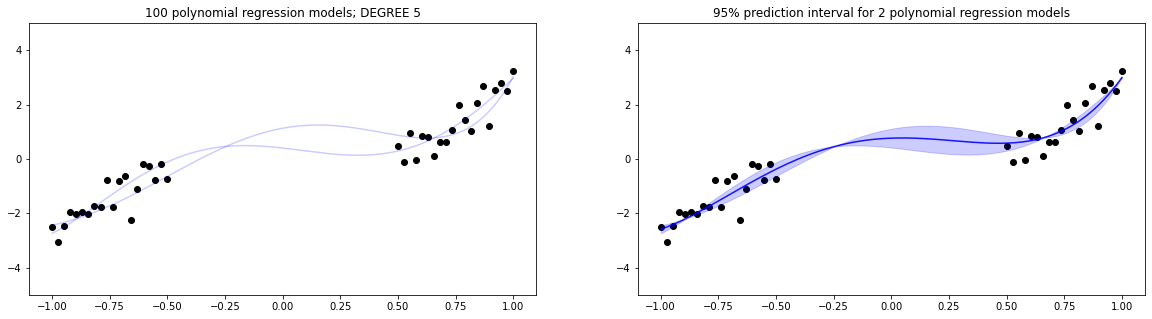

bootstrap: 0
The Mean Squared Error of this bootstrapped poly regression model of degree  10  is  15.817451388964258
The Mean Squared Error of this bootstrapped poly regression model of degree  10  is  3.9121101944998973


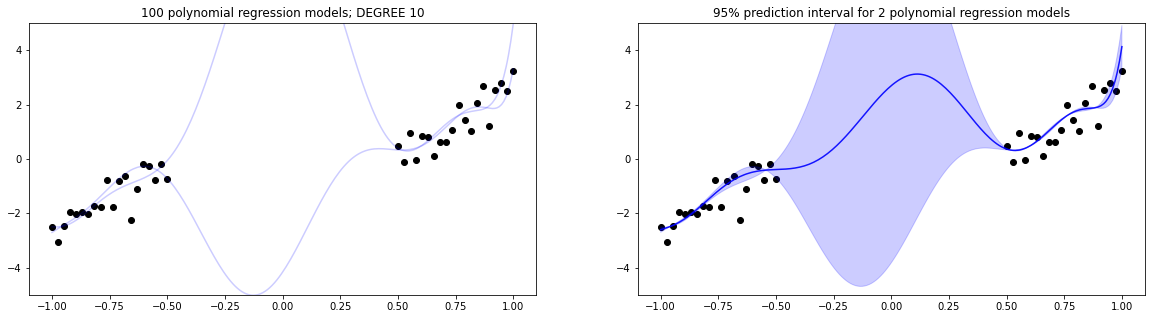

bootstrap: 0
The Mean Squared Error of this bootstrapped poly regression model of degree  15  is  1594.8518795104985
The Mean Squared Error of this bootstrapped poly regression model of degree  15  is  23398.04026454412


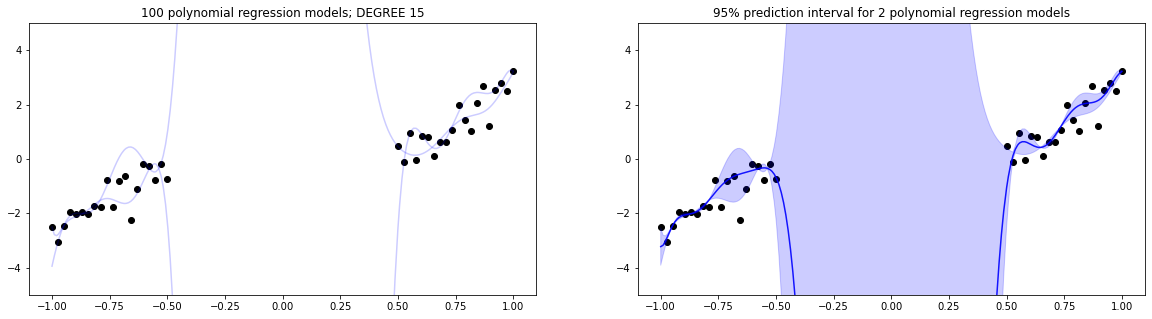

bootstrap: 0
The Mean Squared Error of this bootstrapped poly regression model of degree  20  is  8477583.483160814
The Mean Squared Error of this bootstrapped poly regression model of degree  20  is  61358.674326086046


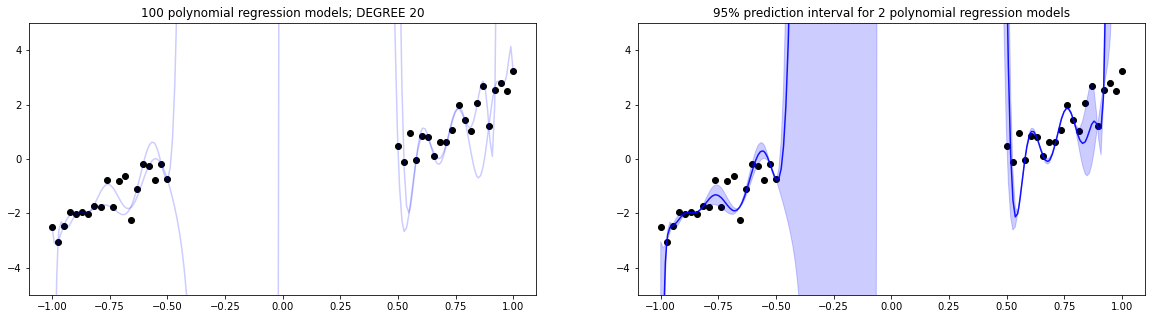

bootstrap: 0
The Mean Squared Error of this bootstrapped poly regression model of degree  50  is  3983481046.142656
The Mean Squared Error of this bootstrapped poly regression model of degree  50  is  4430898369539.511


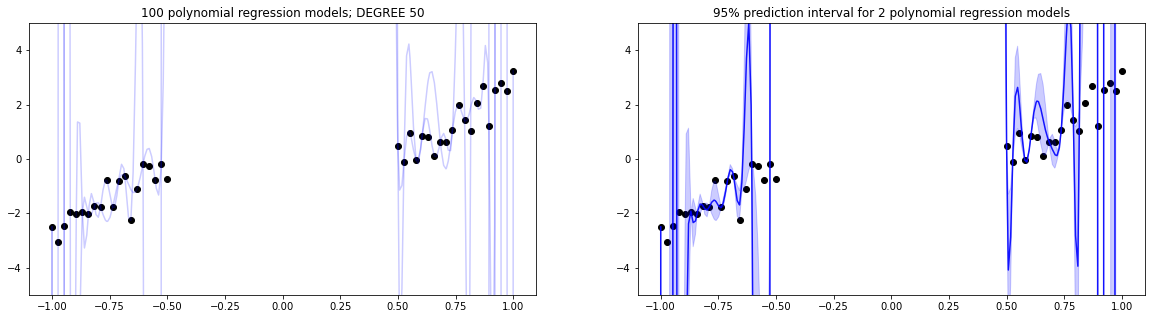

bootstrap: 0
The Mean Squared Error of this bootstrapped poly regression model of degree  100  is  6401117552640.464
The Mean Squared Error of this bootstrapped poly regression model of degree  100  is  996846759261837.6


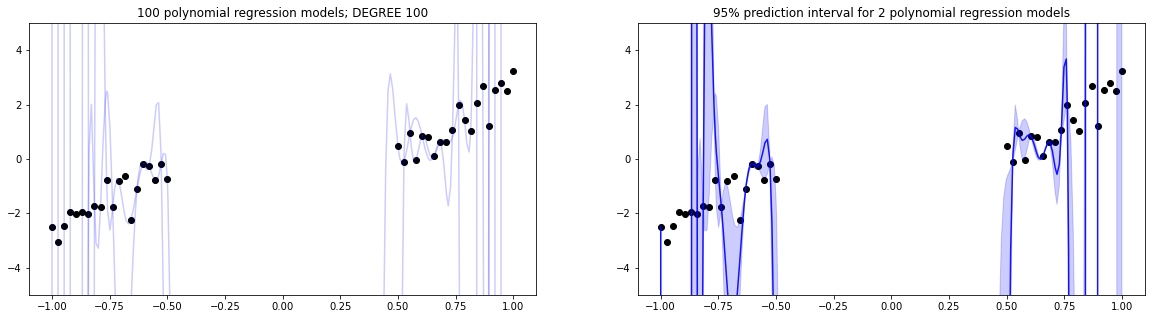

In [33]:
#Define Degrees of Interest
D = [1,3,5,10,15,20,50,100]


for i in D:
    makepolymodel(i)

3. **(Uncertainty Estimation)** As you have seen in HW0, we often use the bootstrap predictive uncertainty of MLE models as an indicator of our confidence in the model's output. Increasingly, in practice, decisions making are deferred to human experts when the model's predictive uncertainty is too high. <br><br>
Given your understanding of the dataset, describe what the model uncertainty ***should*** ideally look like across the input space (i.e. if you plotted the model uncertainty as a function of $x$, what would it look like)? Justify your answer: consider the context of the problem: the test input has undergone covariate shift and is dissmilar to the training input, what kind of uncertainty would help you mitigate risk under this condition?<br><br>
A common practice for estimating predictive uncertainty is to fit a large number of (bootstrap) models on the training data (this collection of models is called an **ensemble**) and, at an input $x$, use the variance of the ensemble predictions to estimate the uncertainty at $x$. Plot the 95% predictive interval of 200 bootstrap MLE polynomial models for each degree $D=[1,3,5,10,15,20,50,100]$, arrange your plots as  subplots in a single figure. For which polynomial degree do you obtain the predictive uncertainty that is most ideal (according to your description above)? Is this the degree you selected in Problem 2? Explain why you would or would not expect the optimal degree in Problem 2 to yield the most ideal uncertainty estimate.<br><br>
Make the same plots the 95% predictive intervals for degrees $D=[1,3,5,10,15,20,50,100]$, with models fitted on larger training datasets - set `number_of_points` to 50, 100, 500, 1000 (arrange all these plots in a single figure). What is happening to the predictions of the ensemble in the training data rich region? What is happening to the predictions of the ensemble in the training data poor region? Are these expected behaviours (relate what you see in both cases to the asymptotic properties of MLE)?
<br><br>
When the training data is abundant (`number_of_points=1000`), are any of the 95% predictive intervals ideal (according to your description above)? What does this imply about the feasibility of using the variance of the ensemble predictions to estimate predictive uncertainty at an input $x$?

***My Answer Attempt.***

If I plotted the degrees of the polynomial (as x), I would expect that the early degrees of 1,3, 5... look "good" with low MSE whereas much higher degrees such as 20, 50, 100... look terrible with high MSE as they overfit the data. We can consider underfit with the lowest degrees as well.

From the 95% intervals, we do not want "excessive" amounts of the plot to be covered, as then there is room for overfitting. However, we need a good amount to cover all of our data points, so degree = 1 may not be the best either. Perhaps degree = 3 or 5 is the best, as it fits the model with a reasonable predictive interval. I would be comfortable sending this model out to deployment.

From observation, as we increase the number of samples, the higher degree polynomials tend to NOT overfit as badly. Considering properties of MLE such as consistency, I can see why this is the case. Further study is required from me to decide if using variance is feasible, as MSE may not tell me the whole story when differing the number of samples.

bootstrap: 0
bootstrap: 10
bootstrap: 20
bootstrap: 30
bootstrap: 40
bootstrap: 50
bootstrap: 60
bootstrap: 70
bootstrap: 80
bootstrap: 90
bootstrap: 100
bootstrap: 110
bootstrap: 120
bootstrap: 130
bootstrap: 140
bootstrap: 150
bootstrap: 160
bootstrap: 170
bootstrap: 180
bootstrap: 190


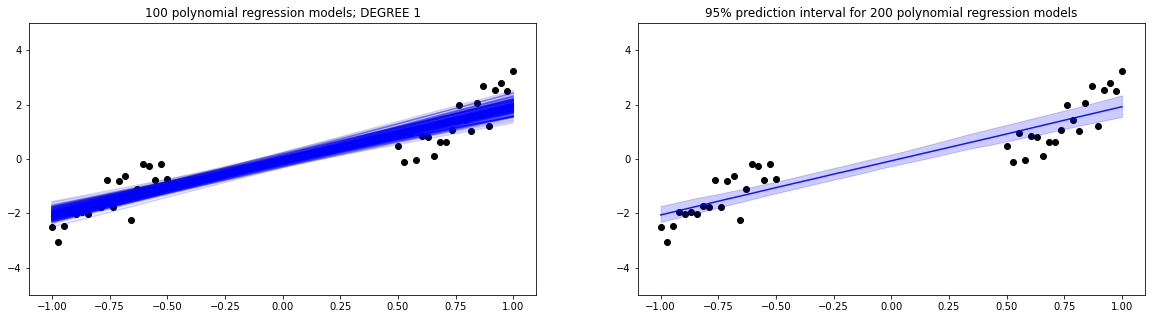

bootstrap: 0
bootstrap: 10
bootstrap: 20
bootstrap: 30
bootstrap: 40
bootstrap: 50
bootstrap: 60
bootstrap: 70
bootstrap: 80
bootstrap: 90
bootstrap: 100
bootstrap: 110
bootstrap: 120
bootstrap: 130
bootstrap: 140
bootstrap: 150
bootstrap: 160
bootstrap: 170
bootstrap: 180
bootstrap: 190


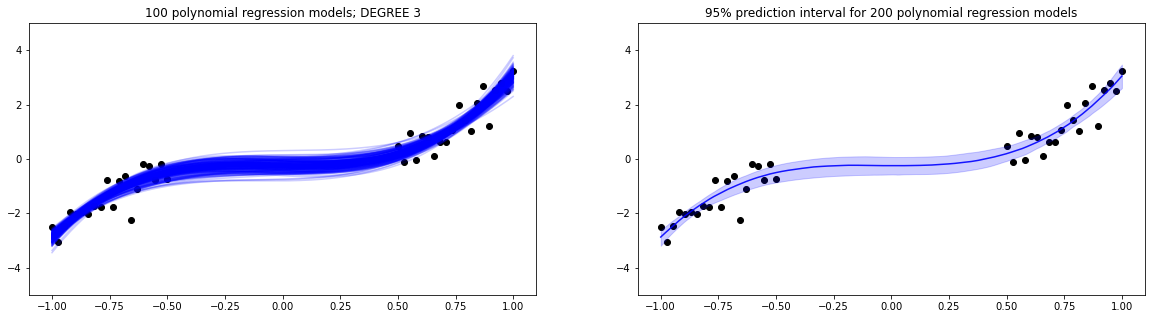

bootstrap: 0
bootstrap: 10
bootstrap: 20
bootstrap: 30
bootstrap: 40
bootstrap: 50
bootstrap: 60
bootstrap: 70
bootstrap: 80
bootstrap: 90
bootstrap: 100
bootstrap: 110
bootstrap: 120
bootstrap: 130
bootstrap: 140
bootstrap: 150
bootstrap: 160
bootstrap: 170
bootstrap: 180
bootstrap: 190


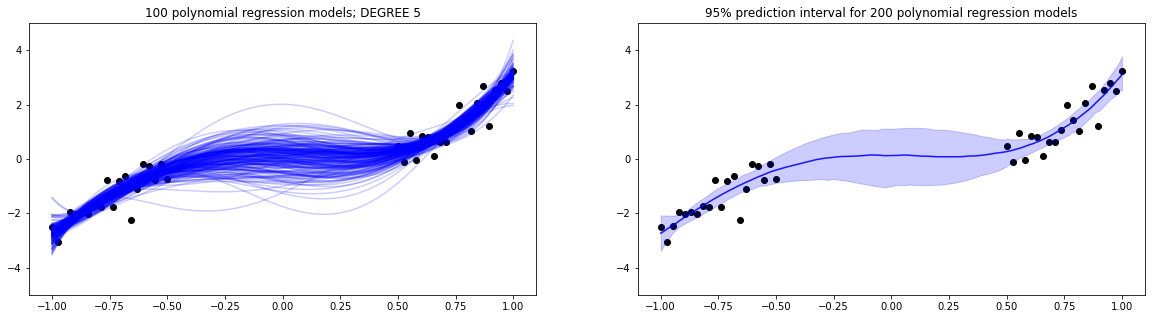

bootstrap: 0
bootstrap: 10
bootstrap: 20
bootstrap: 30
bootstrap: 40
bootstrap: 50
bootstrap: 60
bootstrap: 70
bootstrap: 80
bootstrap: 90
bootstrap: 100
bootstrap: 110
bootstrap: 120
bootstrap: 130
bootstrap: 140
bootstrap: 150
bootstrap: 160
bootstrap: 170
bootstrap: 180
bootstrap: 190


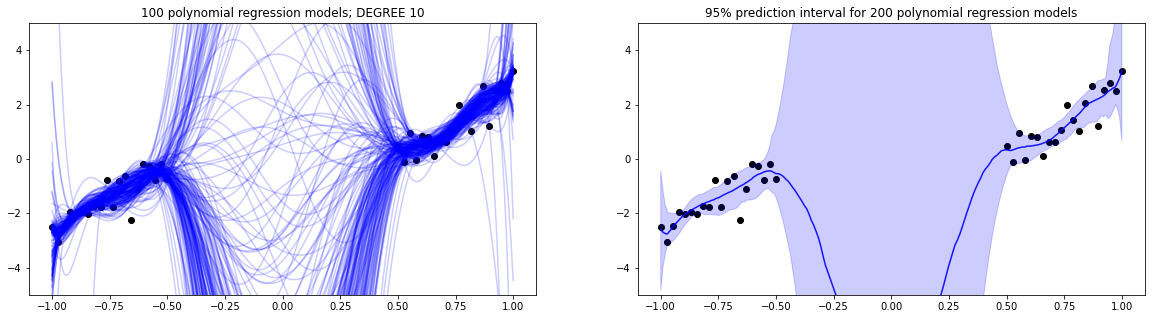

bootstrap: 0
bootstrap: 10
bootstrap: 20
bootstrap: 30
bootstrap: 40
bootstrap: 50
bootstrap: 60
bootstrap: 70
bootstrap: 80
bootstrap: 90
bootstrap: 100
bootstrap: 110
bootstrap: 120
bootstrap: 130
bootstrap: 140
bootstrap: 150
bootstrap: 160
bootstrap: 170
bootstrap: 180
bootstrap: 190


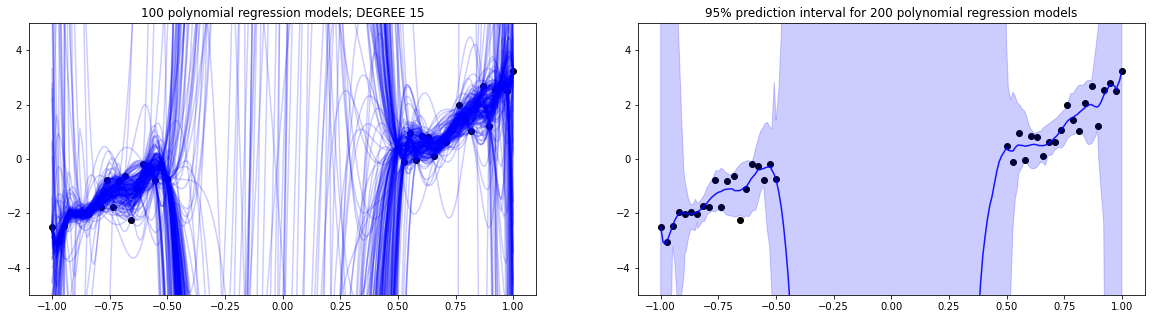

bootstrap: 0
bootstrap: 10
bootstrap: 20
bootstrap: 30
bootstrap: 40
bootstrap: 50
bootstrap: 60
bootstrap: 70
bootstrap: 80
bootstrap: 90
bootstrap: 100
bootstrap: 110
bootstrap: 120
bootstrap: 130
bootstrap: 140
bootstrap: 150
bootstrap: 160
bootstrap: 170
bootstrap: 180
bootstrap: 190


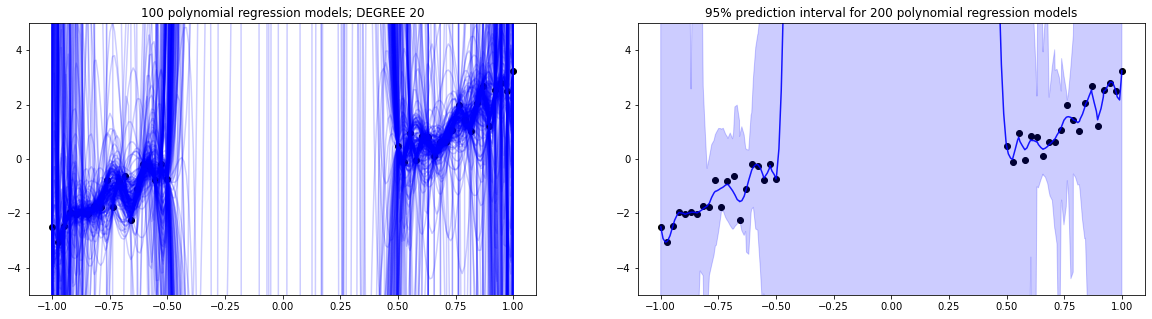

bootstrap: 0
bootstrap: 10
bootstrap: 20
bootstrap: 30
bootstrap: 40
bootstrap: 50
bootstrap: 60
bootstrap: 70
bootstrap: 80
bootstrap: 90
bootstrap: 100
bootstrap: 110
bootstrap: 120
bootstrap: 130
bootstrap: 140
bootstrap: 150
bootstrap: 160
bootstrap: 170
bootstrap: 180
bootstrap: 190


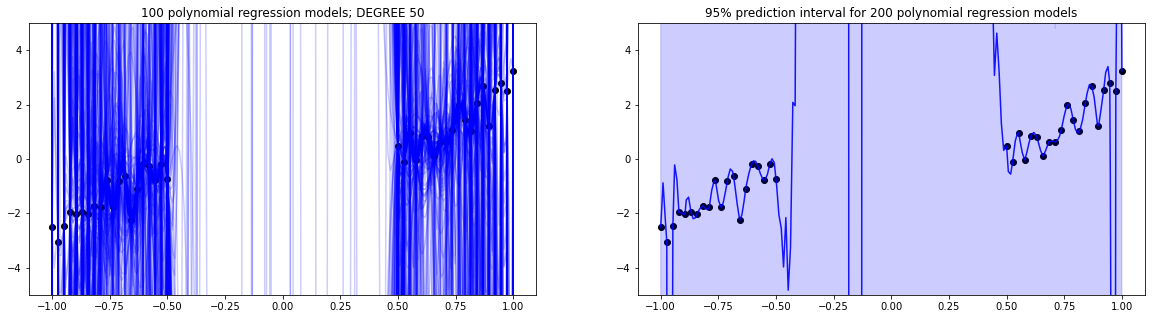

bootstrap: 0
bootstrap: 10
bootstrap: 20
bootstrap: 30
bootstrap: 40
bootstrap: 50
bootstrap: 60
bootstrap: 70
bootstrap: 80
bootstrap: 90
bootstrap: 100
bootstrap: 110
bootstrap: 120
bootstrap: 130
bootstrap: 140
bootstrap: 150
bootstrap: 160
bootstrap: 170
bootstrap: 180
bootstrap: 190


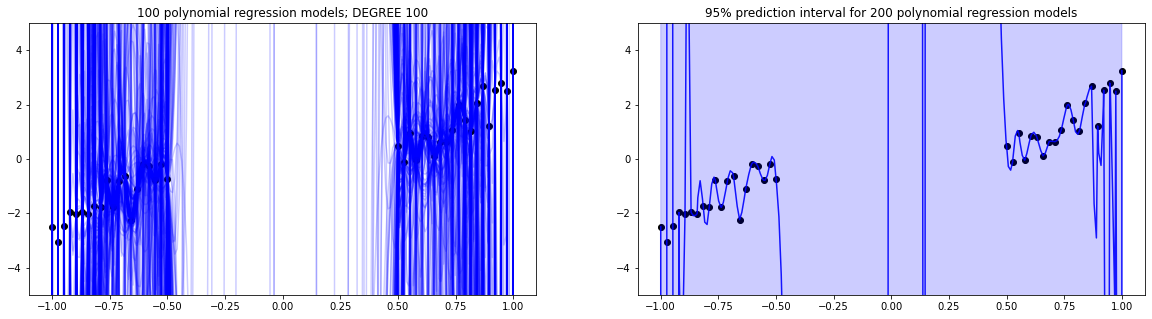

In [36]:
def makepolymodel(degree=1):
    # Make an instance of the PolynomialFeatures model to add polynomial powers to our covariates
    poly = PolynomialFeatures(degree)

    # Make an instance of the LinearRegression to perform regression
    linear_model = LinearRegression(fit_intercept=False)

    # Number of boostrap polyomial models to fit - MODIFIED TO 200
    trials = 200
    # Make a list to record all model predictions
    y_test_poly = []

    # Bootstrap 100 training sets and fit a polynomial regression model on each
    for i in range(trials):

        if i % 10 == 0:
            print('bootstrap:', i)

        # Generate a bootstrap sample from the data
        indices = np.random.choice(np.arange(len(x_train)), size=len(x_train))
        bootstrap_x = x_train[indices]
        bootstrap_y = y_train[indices]

        # Fit a polynomial model
        bootstrap_x_poly = poly.fit_transform(bootstrap_x.reshape((-1, 1)))
        bootstrap_x_test_poly = poly.fit_transform(x_test.reshape((-1, 1)))
        linear_model.fit(bootstrap_x_poly, bootstrap_y)

        # Predict on x_test
        y_test = linear_model.predict(bootstrap_x_test_poly)
        y_test_poly.append(y_test)
        
    y_test_poly = np.array(y_test_poly)

    # Compute the 97.5 th percentile of the posterior predictive predictions
    y_test_poly_ub = np.percentile(y_test_poly, 97.5, axis=0)

    # Compute the 50 th percentile of the posterior predictive predictions
    y_test_poly_mean = np.percentile(y_test_poly, 50.0, axis=0)

    # Compute the 2.5 th percentile of the posterior predictive predictions
    y_test_poly_lb = np.percentile(y_test_poly, 2.5, axis=0)

    # Visualize these 100 boostrap models and visualize their 95% posterior predictive interval
    fig, ax = plt.subplots(1, 2, figsize=(20, 5))
    ax[0].scatter(x_train, y_train, color='black', label='data')
    ax[1].scatter(x_train, y_train, color='black', label='data')

    # Plot the 100 polynomial models; D=1
    for y_poly in y_test_poly:
        ax[0].plot(x_test, y_poly, color='blue', alpha=0.2)

    ax[0].set_ylim([-5, 5])
    ax[0].set_title('100 polynomial regression models; DEGREE '+str(degree).format(trials))

    # Plot 95% predictive interval
    ax[1].fill_between(x_test, y_test_poly_ub, y_test_poly_lb, color='blue', alpha=0.2)
    ax[1].plot(x_test, y_test_poly_mean, color='blue', alpha=0.9)

    ax[1].set_ylim([-5, 5])
    ax[1].set_title('95% prediction interval for {} polynomial regression models'.format(trials))

    plt.show()
    
#Define Degrees of Interest
D = [1,3,5,10,15,20,50,100]


for i in D:
    makepolymodel(i)

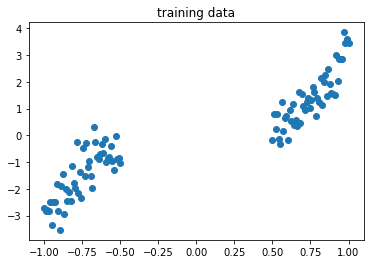

bootstrap: 0
bootstrap: 10
bootstrap: 20
bootstrap: 30
bootstrap: 40
bootstrap: 50
bootstrap: 60
bootstrap: 70
bootstrap: 80
bootstrap: 90
bootstrap: 100
bootstrap: 110
bootstrap: 120
bootstrap: 130
bootstrap: 140
bootstrap: 150
bootstrap: 160
bootstrap: 170
bootstrap: 180
bootstrap: 190


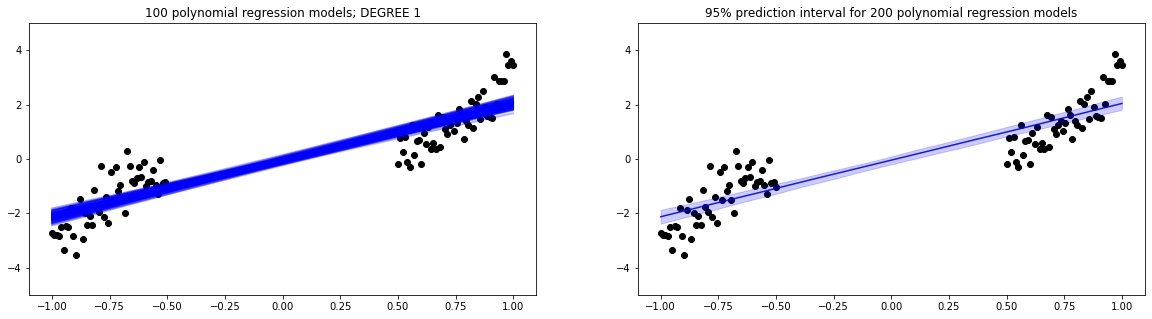

bootstrap: 0
bootstrap: 10
bootstrap: 20
bootstrap: 30
bootstrap: 40
bootstrap: 50
bootstrap: 60
bootstrap: 70
bootstrap: 80
bootstrap: 90
bootstrap: 100
bootstrap: 110
bootstrap: 120
bootstrap: 130
bootstrap: 140
bootstrap: 150
bootstrap: 160
bootstrap: 170
bootstrap: 180
bootstrap: 190


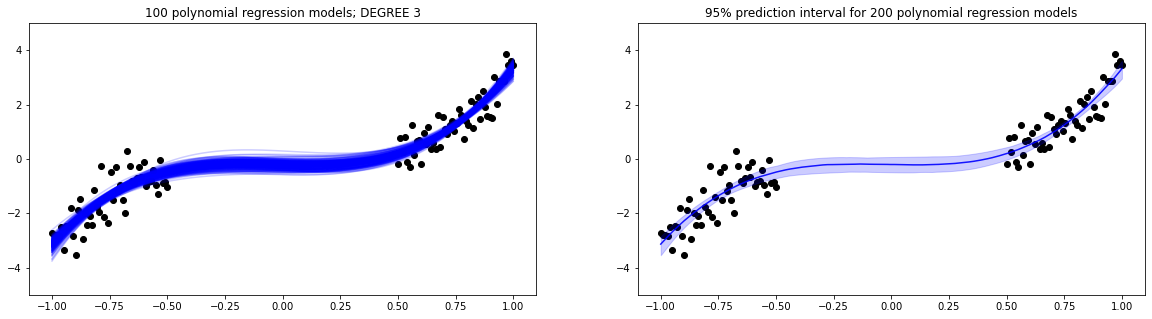

bootstrap: 0
bootstrap: 10
bootstrap: 20
bootstrap: 30
bootstrap: 40
bootstrap: 50
bootstrap: 60
bootstrap: 70
bootstrap: 80
bootstrap: 90
bootstrap: 100
bootstrap: 110
bootstrap: 120
bootstrap: 130
bootstrap: 140
bootstrap: 150
bootstrap: 160
bootstrap: 170
bootstrap: 180
bootstrap: 190


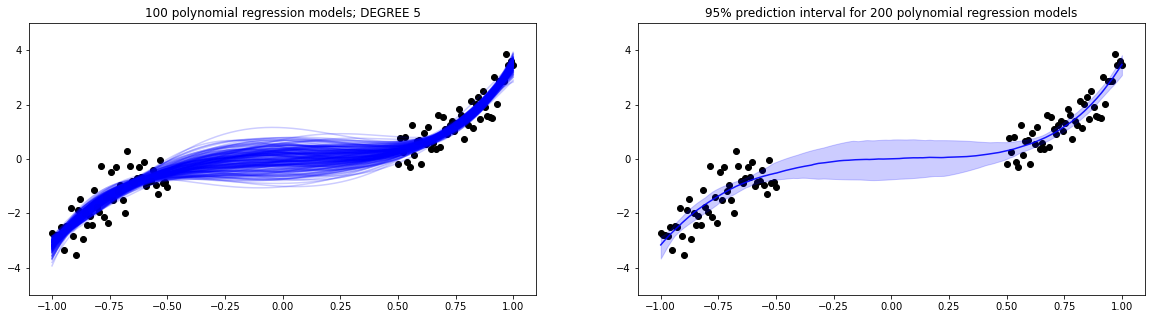

bootstrap: 0
bootstrap: 10
bootstrap: 20
bootstrap: 30
bootstrap: 40
bootstrap: 50
bootstrap: 60
bootstrap: 70
bootstrap: 80
bootstrap: 90
bootstrap: 100
bootstrap: 110
bootstrap: 120
bootstrap: 130
bootstrap: 140
bootstrap: 150
bootstrap: 160
bootstrap: 170
bootstrap: 180
bootstrap: 190


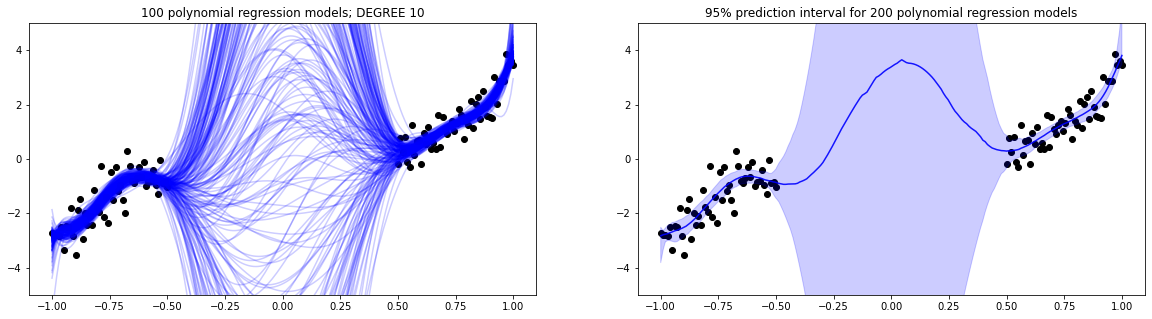

bootstrap: 0
bootstrap: 10
bootstrap: 20
bootstrap: 30
bootstrap: 40
bootstrap: 50
bootstrap: 60
bootstrap: 70
bootstrap: 80
bootstrap: 90
bootstrap: 100
bootstrap: 110
bootstrap: 120
bootstrap: 130
bootstrap: 140
bootstrap: 150
bootstrap: 160
bootstrap: 170
bootstrap: 180
bootstrap: 190


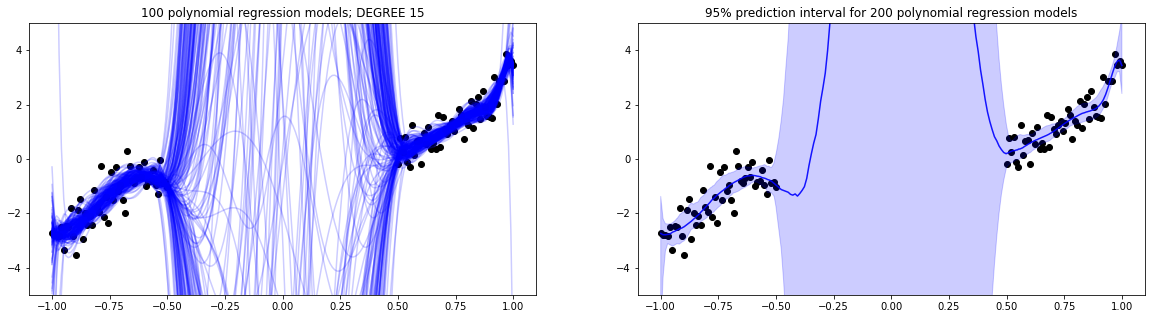

bootstrap: 0
bootstrap: 10
bootstrap: 20
bootstrap: 30
bootstrap: 40
bootstrap: 50
bootstrap: 60
bootstrap: 70
bootstrap: 80
bootstrap: 90
bootstrap: 100
bootstrap: 110
bootstrap: 120
bootstrap: 130
bootstrap: 140
bootstrap: 150
bootstrap: 160
bootstrap: 170
bootstrap: 180
bootstrap: 190


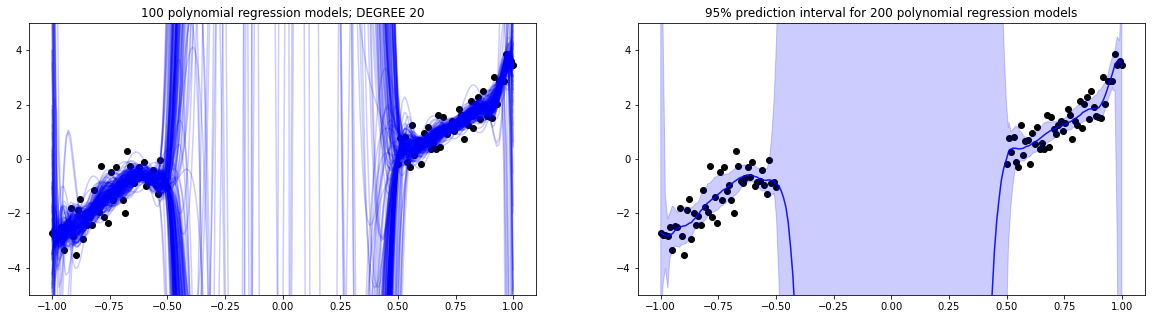

bootstrap: 0
bootstrap: 10
bootstrap: 20
bootstrap: 30
bootstrap: 40
bootstrap: 50
bootstrap: 60
bootstrap: 70
bootstrap: 80
bootstrap: 90
bootstrap: 100
bootstrap: 110
bootstrap: 120
bootstrap: 130
bootstrap: 140
bootstrap: 150
bootstrap: 160
bootstrap: 170
bootstrap: 180
bootstrap: 190


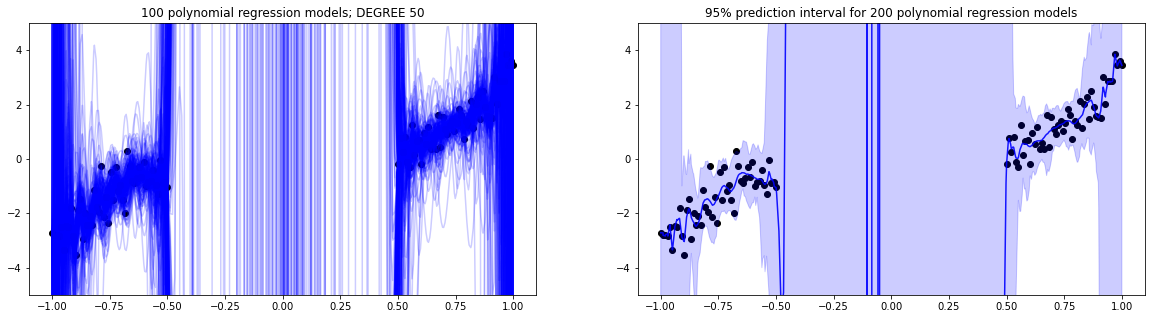

bootstrap: 0
bootstrap: 10
bootstrap: 20
bootstrap: 30
bootstrap: 40
bootstrap: 50
bootstrap: 60
bootstrap: 70
bootstrap: 80
bootstrap: 90
bootstrap: 100
bootstrap: 110
bootstrap: 120
bootstrap: 130
bootstrap: 140
bootstrap: 150
bootstrap: 160
bootstrap: 170
bootstrap: 180
bootstrap: 190


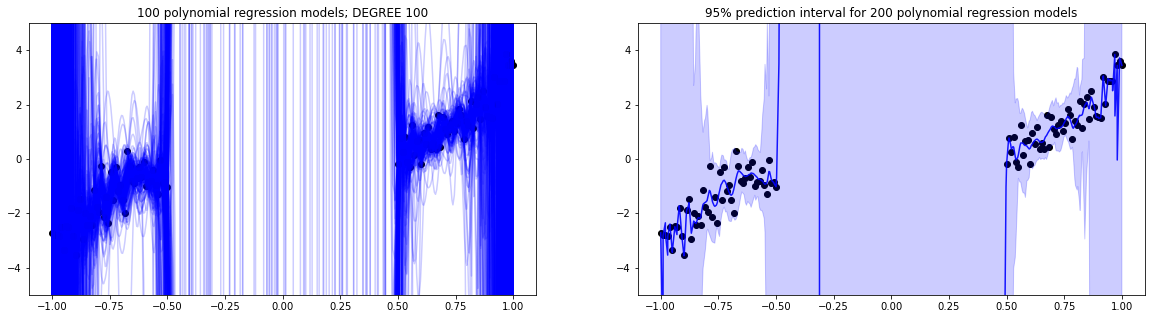

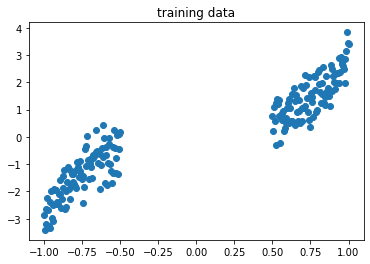

bootstrap: 0
bootstrap: 10
bootstrap: 20
bootstrap: 30
bootstrap: 40
bootstrap: 50
bootstrap: 60
bootstrap: 70
bootstrap: 80
bootstrap: 90
bootstrap: 100
bootstrap: 110
bootstrap: 120
bootstrap: 130
bootstrap: 140
bootstrap: 150
bootstrap: 160
bootstrap: 170
bootstrap: 180
bootstrap: 190


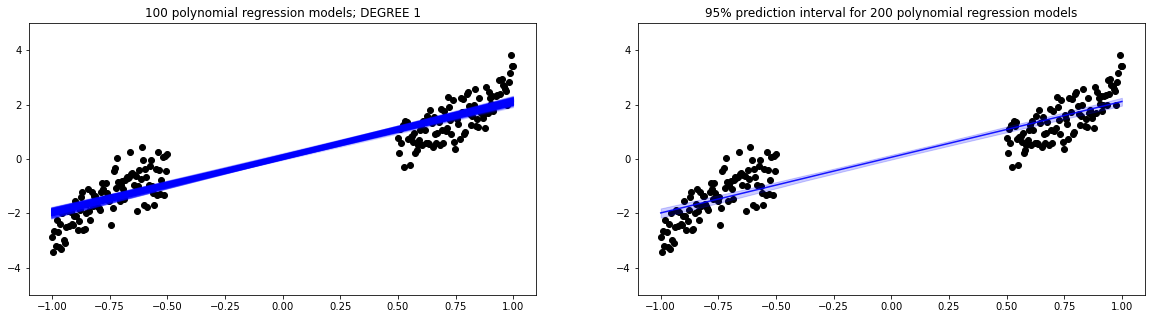

bootstrap: 0
bootstrap: 10
bootstrap: 20
bootstrap: 30
bootstrap: 40
bootstrap: 50
bootstrap: 60
bootstrap: 70
bootstrap: 80
bootstrap: 90
bootstrap: 100
bootstrap: 110
bootstrap: 120
bootstrap: 130
bootstrap: 140
bootstrap: 150
bootstrap: 160
bootstrap: 170
bootstrap: 180
bootstrap: 190


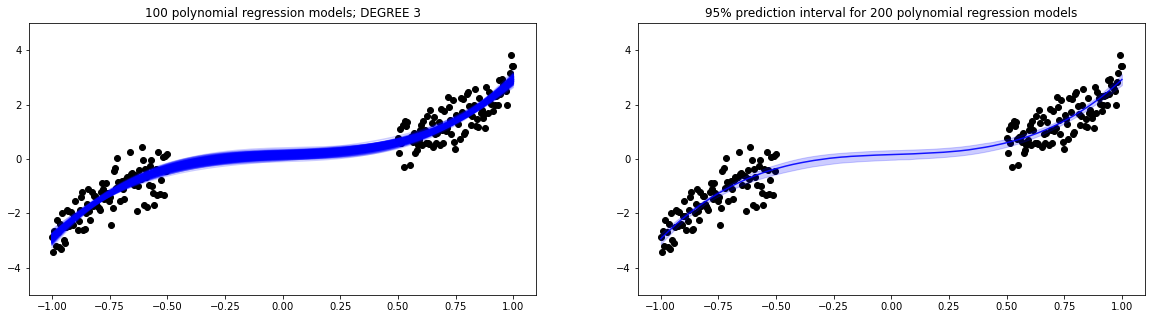

bootstrap: 0
bootstrap: 10
bootstrap: 20
bootstrap: 30
bootstrap: 40
bootstrap: 50
bootstrap: 60
bootstrap: 70
bootstrap: 80
bootstrap: 90
bootstrap: 100
bootstrap: 110
bootstrap: 120
bootstrap: 130
bootstrap: 140
bootstrap: 150
bootstrap: 160
bootstrap: 170
bootstrap: 180
bootstrap: 190


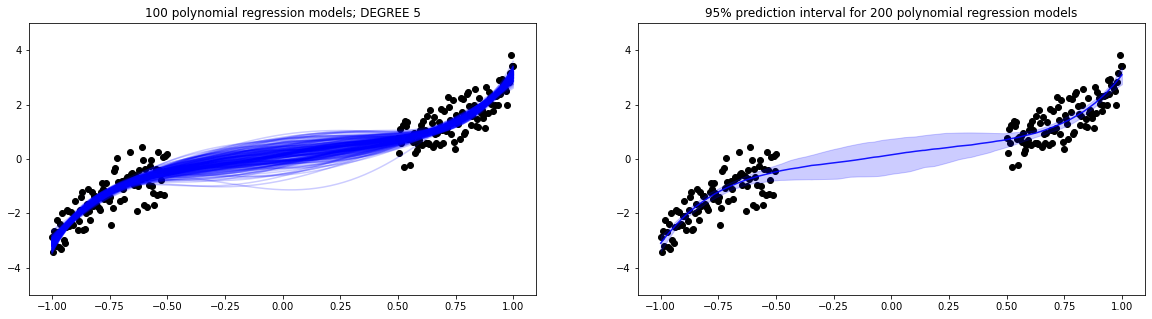

bootstrap: 0
bootstrap: 10
bootstrap: 20
bootstrap: 30
bootstrap: 40
bootstrap: 50
bootstrap: 60
bootstrap: 70
bootstrap: 80
bootstrap: 90
bootstrap: 100
bootstrap: 110
bootstrap: 120
bootstrap: 130
bootstrap: 140
bootstrap: 150
bootstrap: 160
bootstrap: 170
bootstrap: 180
bootstrap: 190


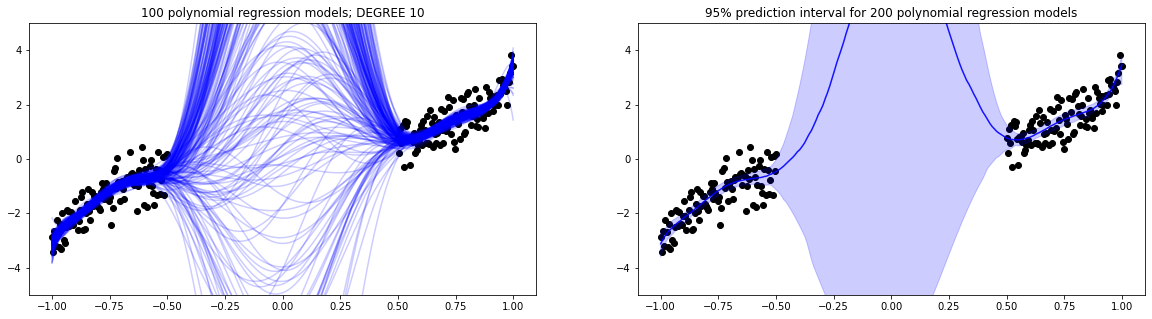

bootstrap: 0
bootstrap: 10
bootstrap: 20
bootstrap: 30
bootstrap: 40
bootstrap: 50
bootstrap: 60
bootstrap: 70
bootstrap: 80
bootstrap: 90
bootstrap: 100
bootstrap: 110
bootstrap: 120
bootstrap: 130
bootstrap: 140
bootstrap: 150
bootstrap: 160
bootstrap: 170
bootstrap: 180
bootstrap: 190


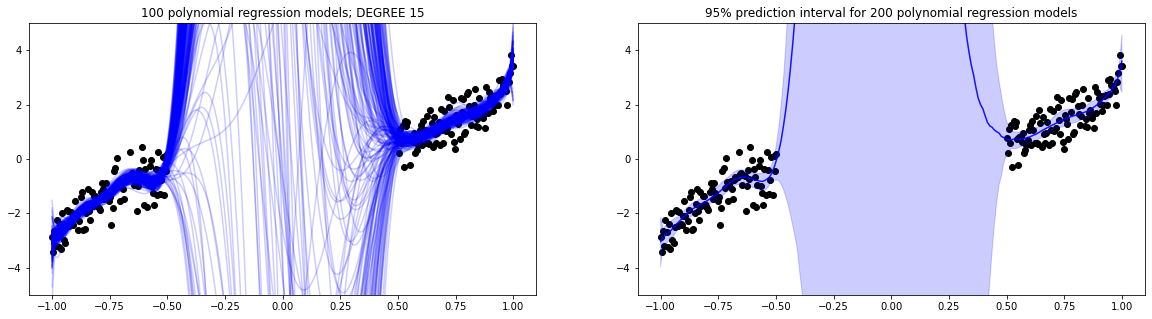

bootstrap: 0
bootstrap: 10
bootstrap: 20
bootstrap: 30
bootstrap: 40
bootstrap: 50
bootstrap: 60
bootstrap: 70
bootstrap: 80
bootstrap: 90
bootstrap: 100
bootstrap: 110
bootstrap: 120
bootstrap: 130
bootstrap: 140
bootstrap: 150
bootstrap: 160
bootstrap: 170
bootstrap: 180
bootstrap: 190


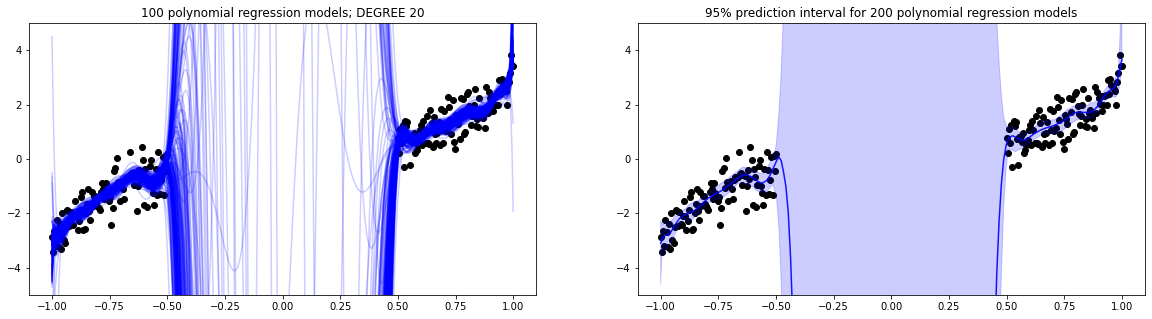

bootstrap: 0
bootstrap: 10
bootstrap: 20
bootstrap: 30
bootstrap: 40
bootstrap: 50
bootstrap: 60
bootstrap: 70
bootstrap: 80
bootstrap: 90
bootstrap: 100
bootstrap: 110
bootstrap: 120
bootstrap: 130
bootstrap: 140
bootstrap: 150
bootstrap: 160
bootstrap: 170
bootstrap: 180
bootstrap: 190


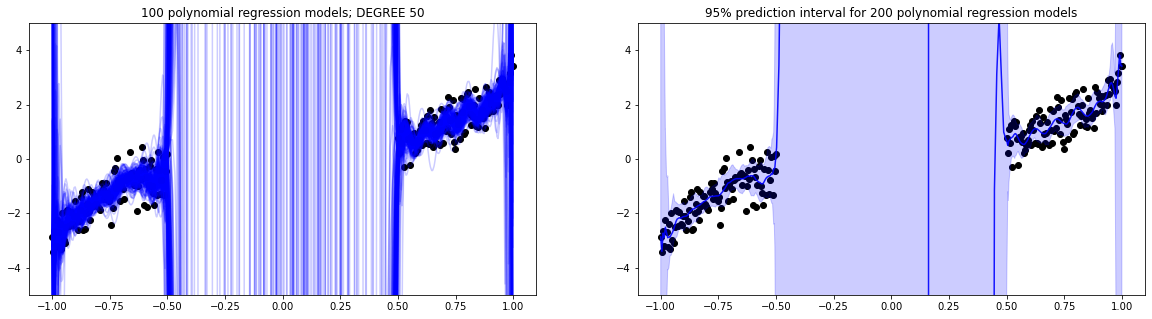

bootstrap: 0
bootstrap: 10
bootstrap: 20
bootstrap: 30
bootstrap: 40
bootstrap: 50
bootstrap: 60
bootstrap: 70
bootstrap: 80
bootstrap: 90
bootstrap: 100
bootstrap: 110
bootstrap: 120
bootstrap: 130
bootstrap: 140
bootstrap: 150
bootstrap: 160
bootstrap: 170
bootstrap: 180
bootstrap: 190


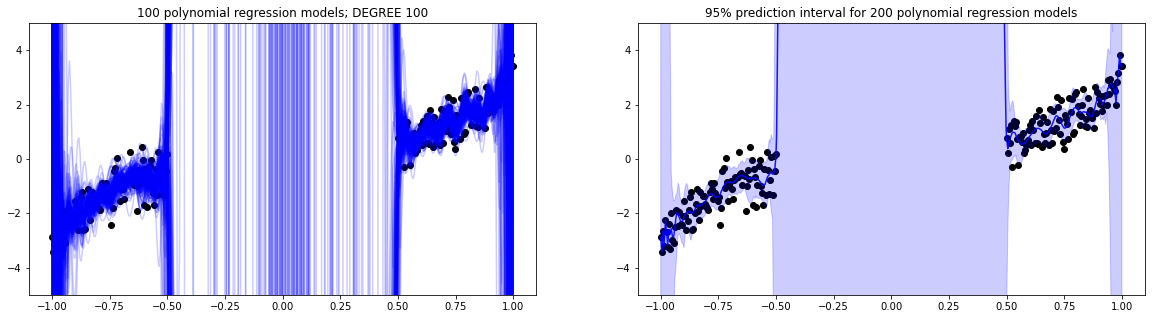

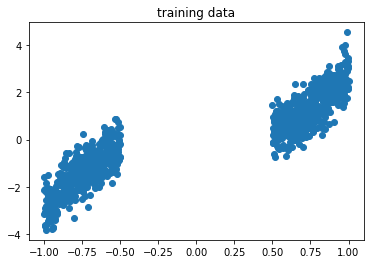

bootstrap: 0
bootstrap: 10
bootstrap: 20
bootstrap: 30
bootstrap: 40
bootstrap: 50
bootstrap: 60
bootstrap: 70
bootstrap: 80
bootstrap: 90
bootstrap: 100
bootstrap: 110
bootstrap: 120
bootstrap: 130
bootstrap: 140
bootstrap: 150
bootstrap: 160
bootstrap: 170
bootstrap: 180
bootstrap: 190


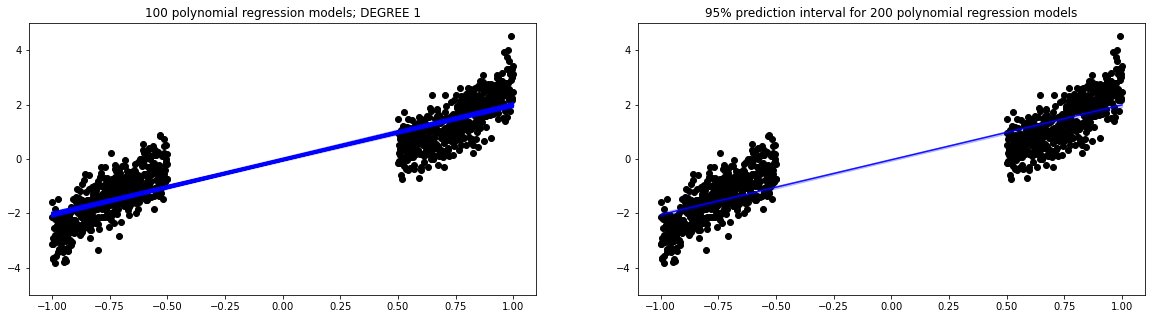

bootstrap: 0
bootstrap: 10
bootstrap: 20
bootstrap: 30
bootstrap: 40
bootstrap: 50
bootstrap: 60
bootstrap: 70
bootstrap: 80
bootstrap: 90
bootstrap: 100
bootstrap: 110
bootstrap: 120
bootstrap: 130
bootstrap: 140
bootstrap: 150
bootstrap: 160
bootstrap: 170
bootstrap: 180
bootstrap: 190


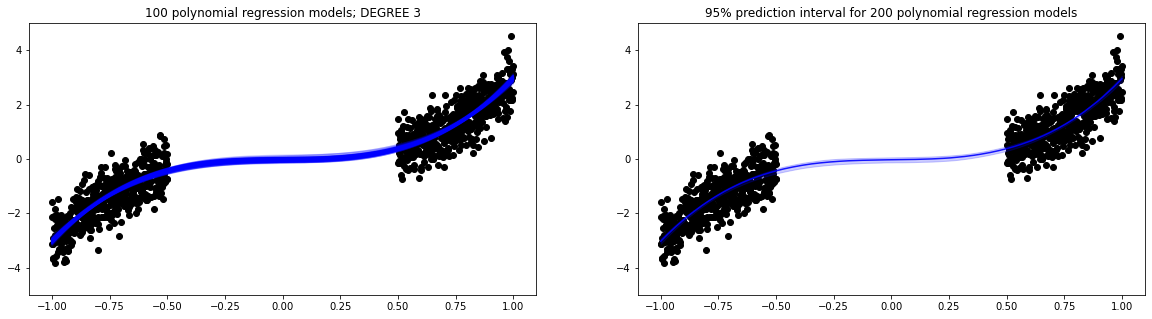

bootstrap: 0
bootstrap: 10
bootstrap: 20
bootstrap: 30
bootstrap: 40
bootstrap: 50
bootstrap: 60
bootstrap: 70
bootstrap: 80
bootstrap: 90
bootstrap: 100
bootstrap: 110
bootstrap: 120
bootstrap: 130
bootstrap: 140
bootstrap: 150
bootstrap: 160
bootstrap: 170
bootstrap: 180
bootstrap: 190


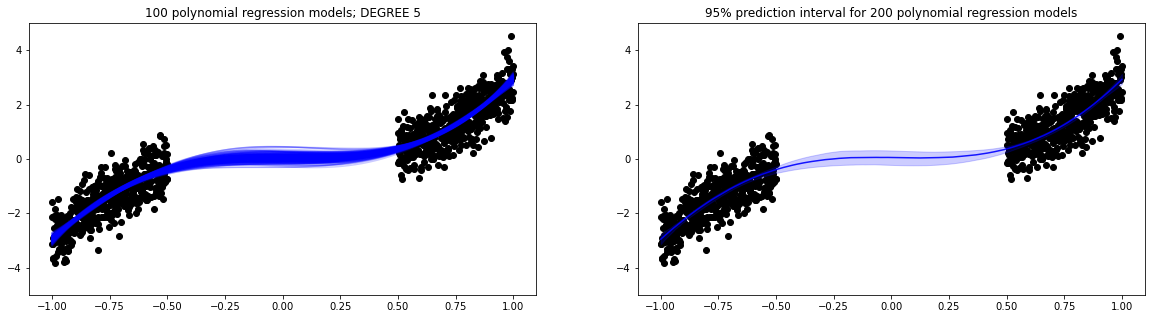

bootstrap: 0
bootstrap: 10
bootstrap: 20
bootstrap: 30
bootstrap: 40
bootstrap: 50
bootstrap: 60
bootstrap: 70
bootstrap: 80
bootstrap: 90
bootstrap: 100
bootstrap: 110
bootstrap: 120
bootstrap: 130
bootstrap: 140
bootstrap: 150
bootstrap: 160
bootstrap: 170
bootstrap: 180
bootstrap: 190


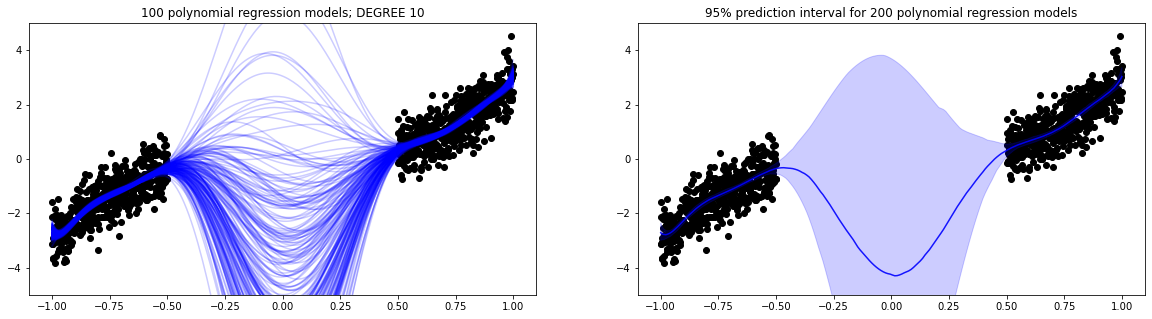

bootstrap: 0
bootstrap: 10
bootstrap: 20
bootstrap: 30
bootstrap: 40
bootstrap: 50
bootstrap: 60
bootstrap: 70
bootstrap: 80
bootstrap: 90
bootstrap: 100
bootstrap: 110
bootstrap: 120
bootstrap: 130
bootstrap: 140
bootstrap: 150
bootstrap: 160
bootstrap: 170
bootstrap: 180
bootstrap: 190


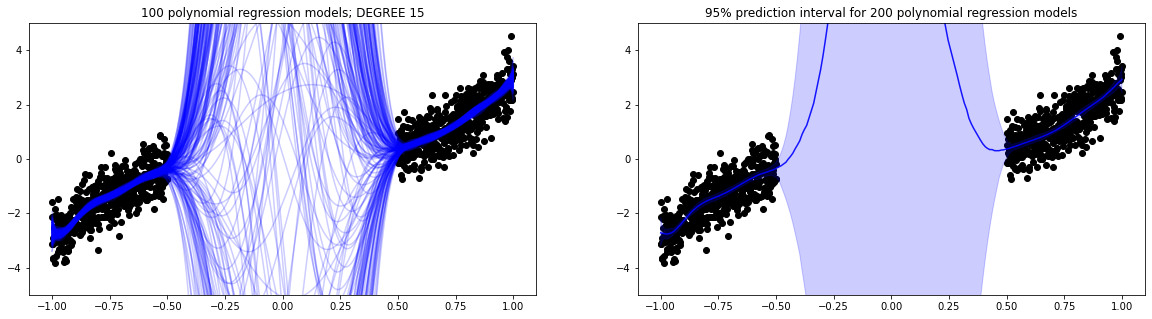

bootstrap: 0
bootstrap: 10
bootstrap: 20
bootstrap: 30
bootstrap: 40
bootstrap: 50
bootstrap: 60
bootstrap: 70
bootstrap: 80
bootstrap: 90
bootstrap: 100
bootstrap: 110
bootstrap: 120
bootstrap: 130
bootstrap: 140
bootstrap: 150
bootstrap: 160
bootstrap: 170
bootstrap: 180
bootstrap: 190


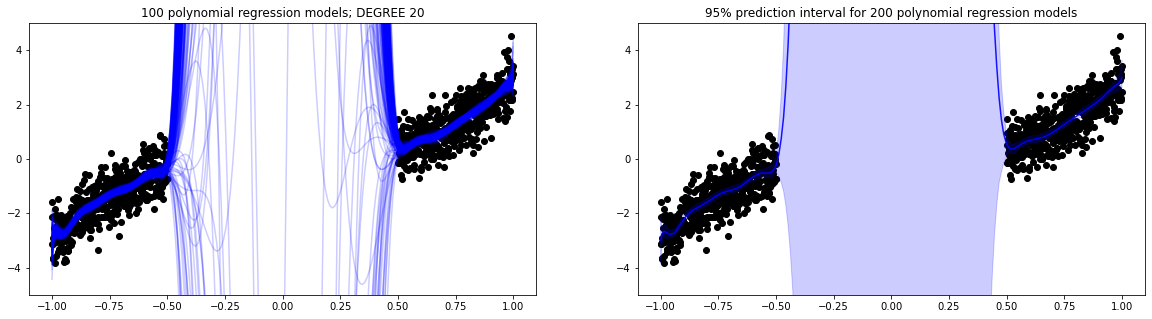

bootstrap: 0
bootstrap: 10
bootstrap: 20
bootstrap: 30
bootstrap: 40
bootstrap: 50
bootstrap: 60
bootstrap: 70
bootstrap: 80
bootstrap: 90
bootstrap: 100
bootstrap: 110
bootstrap: 120
bootstrap: 130
bootstrap: 140
bootstrap: 150
bootstrap: 160
bootstrap: 170
bootstrap: 180
bootstrap: 190


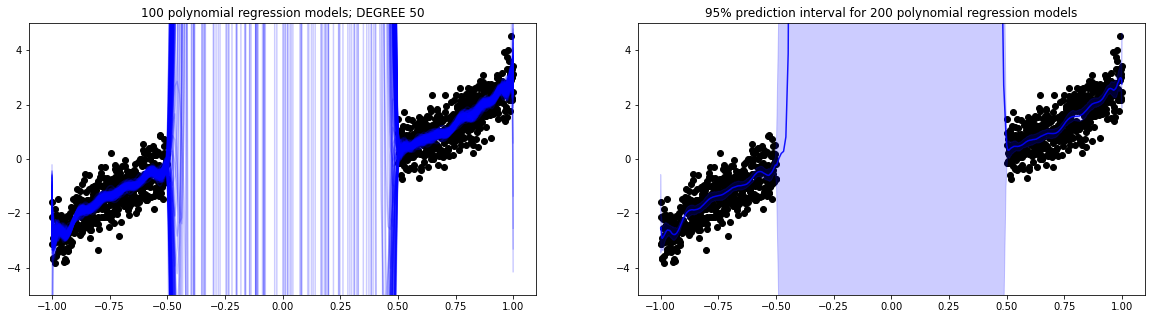

bootstrap: 0
bootstrap: 10
bootstrap: 20
bootstrap: 30
bootstrap: 40
bootstrap: 50
bootstrap: 60
bootstrap: 70
bootstrap: 80
bootstrap: 90
bootstrap: 100
bootstrap: 110
bootstrap: 120
bootstrap: 130
bootstrap: 140
bootstrap: 150
bootstrap: 160
bootstrap: 170
bootstrap: 180
bootstrap: 190


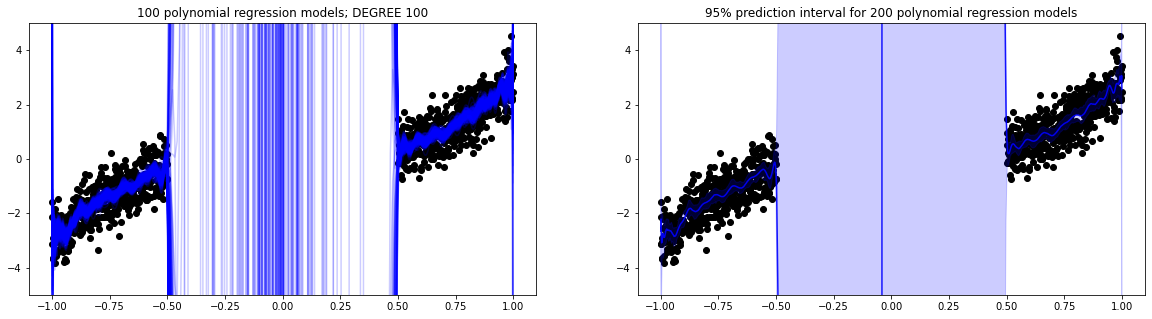

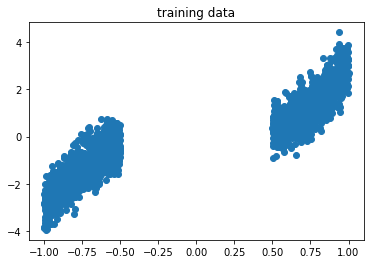

bootstrap: 0
bootstrap: 10
bootstrap: 20
bootstrap: 30
bootstrap: 40
bootstrap: 50
bootstrap: 60
bootstrap: 70
bootstrap: 80
bootstrap: 90
bootstrap: 100
bootstrap: 110
bootstrap: 120
bootstrap: 130
bootstrap: 140
bootstrap: 150
bootstrap: 160
bootstrap: 170
bootstrap: 180
bootstrap: 190


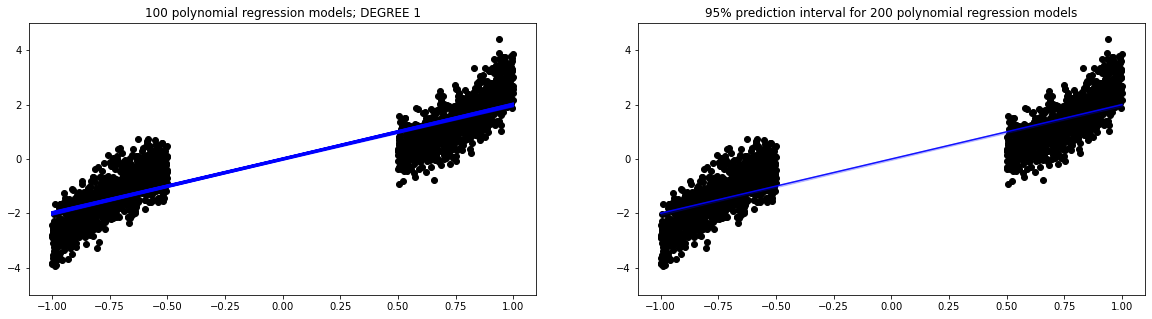

bootstrap: 0
bootstrap: 10
bootstrap: 20
bootstrap: 30
bootstrap: 40
bootstrap: 50
bootstrap: 60
bootstrap: 70
bootstrap: 80
bootstrap: 90
bootstrap: 100
bootstrap: 110
bootstrap: 120
bootstrap: 130
bootstrap: 140
bootstrap: 150
bootstrap: 160
bootstrap: 170
bootstrap: 180
bootstrap: 190


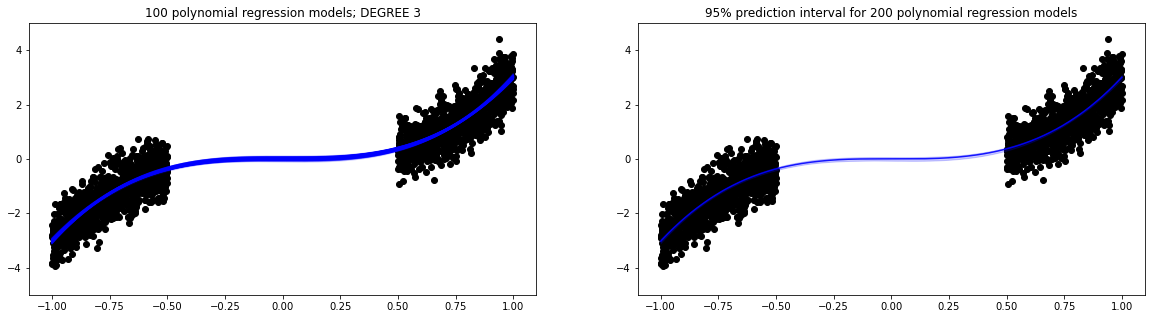

bootstrap: 0
bootstrap: 10
bootstrap: 20
bootstrap: 30
bootstrap: 40
bootstrap: 50
bootstrap: 60
bootstrap: 70
bootstrap: 80
bootstrap: 90
bootstrap: 100
bootstrap: 110
bootstrap: 120
bootstrap: 130
bootstrap: 140
bootstrap: 150
bootstrap: 160
bootstrap: 170
bootstrap: 180
bootstrap: 190


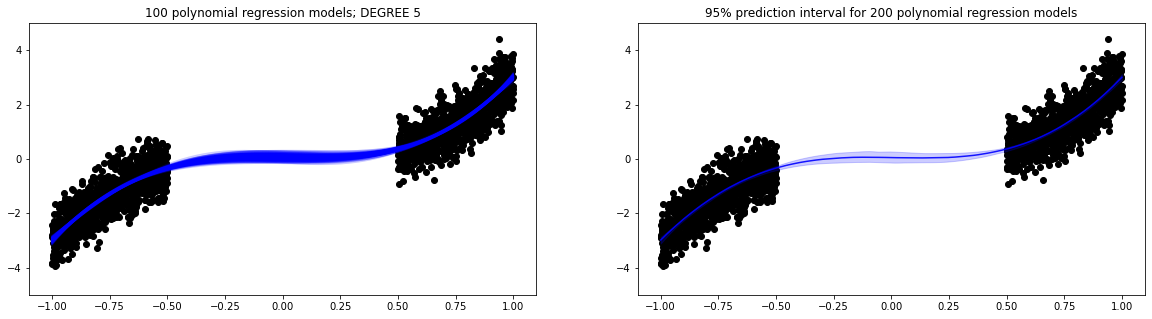

bootstrap: 0
bootstrap: 10
bootstrap: 20
bootstrap: 30
bootstrap: 40
bootstrap: 50
bootstrap: 60
bootstrap: 70
bootstrap: 80
bootstrap: 90
bootstrap: 100
bootstrap: 110
bootstrap: 120
bootstrap: 130
bootstrap: 140
bootstrap: 150
bootstrap: 160
bootstrap: 170
bootstrap: 180
bootstrap: 190


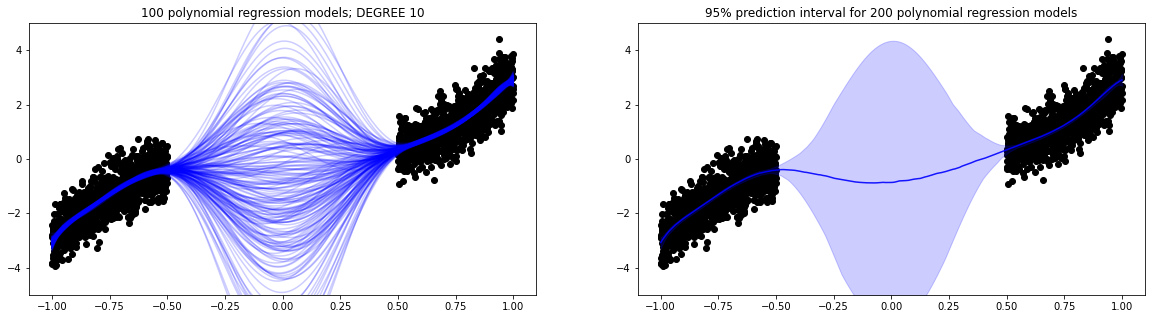

bootstrap: 0
bootstrap: 10
bootstrap: 20
bootstrap: 30
bootstrap: 40
bootstrap: 50
bootstrap: 60
bootstrap: 70
bootstrap: 80
bootstrap: 90
bootstrap: 100
bootstrap: 110
bootstrap: 120
bootstrap: 130
bootstrap: 140
bootstrap: 150
bootstrap: 160
bootstrap: 170
bootstrap: 180
bootstrap: 190


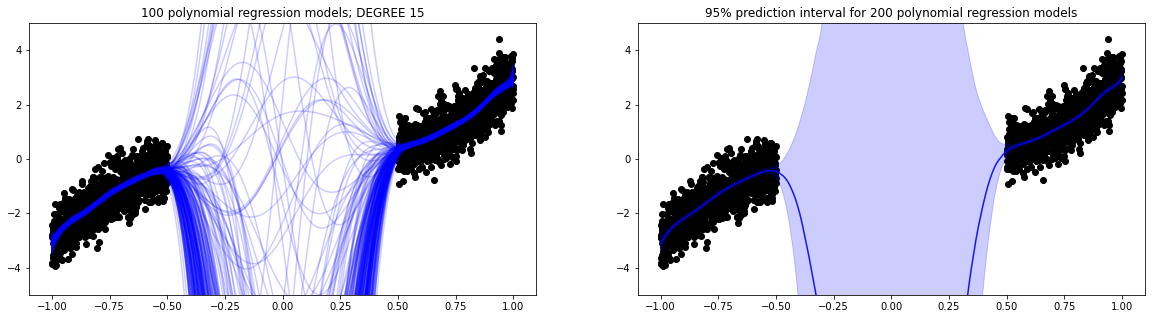

bootstrap: 0
bootstrap: 10
bootstrap: 20
bootstrap: 30
bootstrap: 40
bootstrap: 50
bootstrap: 60
bootstrap: 70
bootstrap: 80
bootstrap: 90
bootstrap: 100
bootstrap: 110
bootstrap: 120
bootstrap: 130
bootstrap: 140
bootstrap: 150
bootstrap: 160
bootstrap: 170
bootstrap: 180
bootstrap: 190


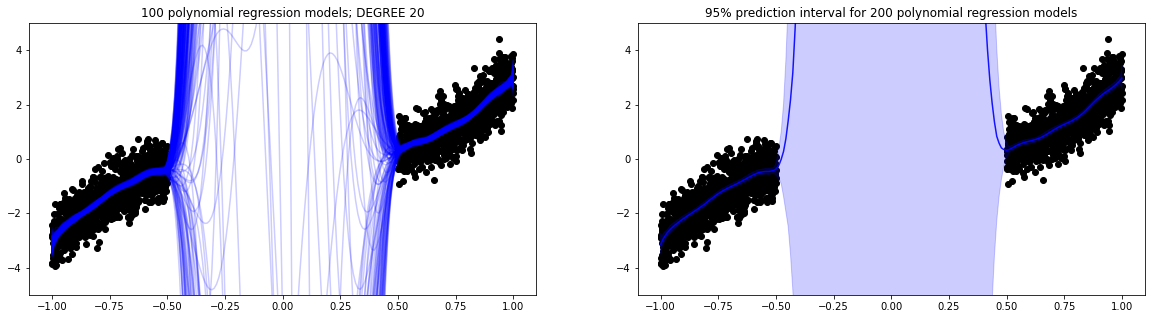

bootstrap: 0
bootstrap: 10
bootstrap: 20
bootstrap: 30
bootstrap: 40
bootstrap: 50
bootstrap: 60
bootstrap: 70
bootstrap: 80
bootstrap: 90
bootstrap: 100
bootstrap: 110
bootstrap: 120
bootstrap: 130
bootstrap: 140
bootstrap: 150
bootstrap: 160
bootstrap: 170
bootstrap: 180
bootstrap: 190


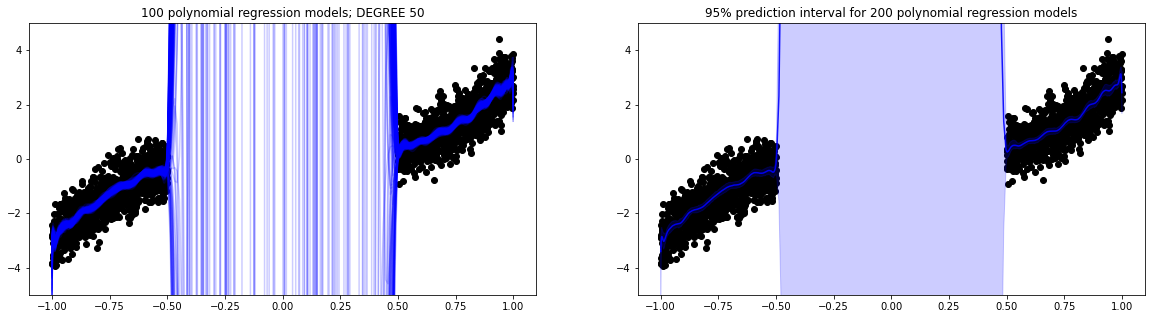

bootstrap: 0
bootstrap: 10
bootstrap: 20
bootstrap: 30
bootstrap: 40
bootstrap: 50
bootstrap: 60
bootstrap: 70
bootstrap: 80
bootstrap: 90
bootstrap: 100
bootstrap: 110
bootstrap: 120
bootstrap: 130
bootstrap: 140
bootstrap: 150
bootstrap: 160
bootstrap: 170
bootstrap: 180
bootstrap: 190


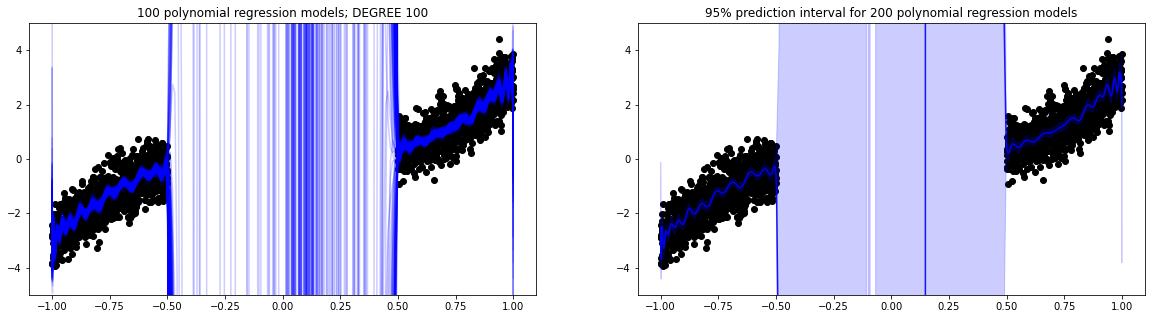

In [37]:
# Observation noise variance
noise_variance = 0.3

#Define Degrees of interest
D = [1,3,5,10,15,20,50,100]

#Define sample sizes of interest
sizeN = [50, 100, 500, 1000]

for i in sizeN:
    # Generate toy data
    x_train, y_train, x_test, y_test = generate_data(i, noise_variance=noise_variance)

    # Plot the training data
    plt.scatter(x_train, y_train)
    plt.title('training data')
    plt.show()

    for i in D:
        makepolymodel(i)

4. **(Effect of Regularization)** In practice, MLE models are nearly always trained with regularization (since they tend to overfit to the training data). Here, we will explore the effect of adding $\ell_2$ regularization to our MLE polynomial models (that is, use the `Ridge` regression model from `sklearn` after augmenting your input with polynomial features). <br><br>
For a toy dataset with 40 observations (`number_of_points=20`), plot the 95% predictive intervals for degrees $D = [1,3,5,10,15,20,50,100]$ and regularization strengths $\alpha = [5e-3, 1e-2, 1e-1, 1e0, 1e1]$ (you should organize these plots in a grid).<br><br>
Describe the effect of regularization on the bootstrap uncertainties. Looking at these results, are the goals of $\ell_2$ regularization and obtaining useful predictive uncertatinty estimation neccessarily well-aligned?


***My Answer Attempt.***

Considering using a Ridge Model further gives me confidence to deploy our statistical model. Particularly, having regularization allows the model to better fit the data despite not having as many samples.

In [ ]:
def polyridgemodel(degree, alpha):
    # Make an instance of the PolynomialFeatures model to add polynomial powers to our covariates
    poly = PolynomialFeatures(degree)

    # Make an instance of the LinearRegression to perform regression
    ridge_model = Ridge(alpha, fit_intercept=False)

    # Number of boostrap polyomial models to fit
    trials = 100
    # Make a list to record all model predictions
    y_test_poly = []

    # Bootstrap 100 training sets and fit a polynomial regression model on each
    for i in range(trials):

        if i % 10 == 0:
            print('bootstrap:', i)

        # Generate a bootstrap sample from the data
        indices = np.random.choice(np.arange(len(x_train)), size=len(x_train))
        bootstrap_x = x_train[indices]
        bootstrap_y = y_train[indices]

        # Fit a polynomial model
        bootstrap_x_poly = poly.fit_transform(bootstrap_x.reshape((-1, 1)))
        bootstrap_x_test_poly = poly.fit_transform(x_test.reshape((-1, 1)))
        ridge_model.fit(bootstrap_x_poly, bootstrap_y)

        # Predict on x_test
        y_test = ridge_model.predict(bootstrap_x_test_poly)
        y_test_poly.append(y_test)

    y_test_poly = np.array(y_test_poly)

    # Compute the 97.5 th percentile of the posterior predictive predictions
    y_test_poly_ub = np.percentile(y_test_poly, 97.5, axis=0)

    # Compute the 50 th percentile of the posterior predictive predictions
    y_test_poly_mean = np.percentile(y_test_poly, 50.0, axis=0)

    # Compute the 2.5 th percentile of the posterior predictive predictions
    y_test_poly_lb = np.percentile(y_test_poly, 2.5, axis=0)

    # Visualize these 100 boostrap models and visualize their 95% posterior predictive interval
    fig, ax = plt.subplots(1, 2, figsize=(20, 5))
    ax[0].scatter(x_train, y_train, color='black', label='data')
    ax[1].scatter(x_train, y_train, color='black', label='data')

    # Plot the 100 polynomial models
    for y_poly in y_test_poly:
        ax[0].plot(x_test, y_poly, color='blue', alpha=0.2)

    ax[0].set_ylim([-5, 5])
    ax[0].set_title('100 polynomial regression models;' +" DEGREE "+str(degree) +" AND ALPHA "+str(alpha).format(trials))

    # Plot 95% predictive interval
    ax[1].fill_between(x_test, y_test_poly_ub, y_test_poly_lb, color='blue', alpha=0.2)
    ax[1].plot(x_test, y_test_poly_mean, color='blue', alpha=0.9)

    ax[1].set_ylim([-5, 5])
    ax[1].set_title('95% prediction interval for {} polynomial regression models'.format(trials))

    plt.show()
    
    


In [ ]:
# Re-generate the data
# Number of data points in each of the two segments of the domain
N = 20

# Observation noise variance
noise_variance = 0.3

# Generate toy data
x_train, y_train, x_test, y_test = generate_data(number_of_points=N, noise_variance=noise_variance)

# Plot the training data
plt.scatter(x_train, y_train)
plt.title('training data')
plt.show()


alpha = [0.005, 0.01, 0.1, 1, 10]

for i in D:
    for j in alpha:
        polyridgemodel(i,j)


## Part II: Bayesian Polynomial Regression
In this problem, your task is to perform Bayesian polynomial regression on the toy datasets in Part I. That is, assume that the outcome $y$ can be modeled by the following process:

\begin{align}
y &= f(x) + \epsilon = w_0 + w_1x + w_2x^2 + \ldots + w_Dx^D + \epsilon, \quad \epsilon \sim \mathcal{N}(0, 0.3)\\
w_d &\sim \mathcal{N}(0, \alpha)
\end{align}

where $\alpha$ is a hyperparameter and must be fixed before modeling and inference begins.

1. **(Bayesian Kernel Regression)** Just as we can treat a polynomial regression model like a multi-linear regression model after ***transforming*** the input data by adding polynomial features. We can treat Bayesian polynomial regression like Bayesian linear regression on top of the transformed inputs. Formally, the map that takes an input $\mathbf{x}_n \in \mathbb{R}^{D'}$ and transforms it into a new input $\phi(\mathbf{x}_n) \in \mathbb{R}^{D}$ is called a **feature map**, $\phi: \mathbb{R}^{D'} \to \mathbb{R}^{D}$, for 1-dimensional input $x \in \mathbb{R}$, the polynomial feature map of degree $D$ is defined by
\begin{align}
\\\phi: \mathbb{R} &\to \mathbb{R}^D\\
x &\mapsto [1, x, x^2, \ldots, x^D]\\
\end{align}
<br> Thus, we can write rewrite Bayesian polynomial regression as
\begin{align}
\\y &= \mathbf{w}^\top \mathbf{x} + \epsilon, \quad \epsilon \sim \mathcal{N}(0, 0.3)\\
\mathbf{w} &\sim \mathcal{N}(0, \alpha I_{D\times D})\\
\end{align}
<br>Denote the $N\times D$ matrix of transformed inputs by $\Phi$, where the $n$-th row of the matrix is the $n$-th input $\mathbf{x}_n$ transformed by the feature map, $\phi(\mathbf{x}_n)$. Using this notation, write out the closed form for the posterior for Bayesian polynomial regression in terms of $\Phi$ (you don't need to rederive anything, just make the appropriate substitutions in the formula you derived in HW0).
<br><br>
For $\alpha = 1$ and $D=5$, visualize the 95% posterior predcitve interval of a Bayesian polynomial regression for the toy dataset with 40 observations (set `number_of_points=20`) in Part I.
<br><br>
When the feature map $\phi$ is a general (usually non-linear transformation), applying Bayesian linear regression on the transformed input is called **Bayesian Kernel Regression**. Choose your own non-linear feature map $\phi: \mathbb{R} \to \mathbb{R}^5$ and visualize the 95% posterior predictive interval of the Bayesian kernel regression for your choice of $\phi$. Compare the visualization to the that for Bayesian polynomial regression. Does the posterior predictive of your Bayesian kernel regression capture important properties of that of the Bayesian polynomial regression model?
<br><br>
**Note:** we highly recommend that you implement the following feature map:
<br><br>
\begin{align}
\phi: \mathbb{R}^{D'} &\to \mathbb{R}^D\\
\mathbf{x} &\mapsto \left[\sqrt{\frac{2}{D}} \cos(w_1^\top x + b_1), \ldots, \sqrt{\frac{2}{D}} \cos(w_D^\top x + b_D)\right]
\end{align}
<br>where $b_d \sim [0, 2\pi]$ and $w_d \sim \mathcal{N}(0, \beta I_{D'\times D'})$ need to be randomly sampled and fixed before modeling and inference. For this exercise, we suggest setting $\beta=10$. The features generated by $\phi$ are called **Random Fourier Features**. As the number of features $D$ tends to infinity, the resulting Bayesian kernel regression model tends to an important type of Bayesian (nonparametric) model called Gaussian Process model. We will revisit the connection between Bayesian kernel regression and Gaussian processes in the latter part of the course.

***My Answer Attempt.***
Recall from the Homework 0 Solutions given, the closed-form of the posterior can be written as:

$$
p(w | \mathbf{y}, \mathbf{X}) = \mathcal{N}\left(\left(S^{-1} + \mathbf{X}^\top\Sigma^{-1}\mathbf{X}\right)^{-1} \left(\mathbf{y}^\top \Sigma^{-1}\mathbf{X} + m^\top S^{-1} \right)^\top, \left(S^{-1} + \mathbf{X}^\top\Sigma^{-1}\mathbf{X}\right)^{-1}\right).
$$

With posterior mean
$$
\left(S^{-1} + \mathbf{X}^\top\Sigma^{-1}\mathbf{X}\right)^{-1} \left(\mathbf{y}^\top \Sigma^{-1}\mathbf{X} + m^\top S^{-1} \right)^\top = \left(S^{-1} + 2\mathbf{X}^\top\mathbf{X}\right)^{-1} \left(2\mathbf{X}^\top\mathbf{y} \right).
$$
and posterior covariance
$$
(S^{-1} + 2\mathbf{X}^\top\mathbf{X})^{-1}
$$

where $m$ is the mean of the joint distribution and $S$ is the covariance.

Note: I attempted to use glm() from pymc3, but was unable to get it to work.

In [ ]:
def makebayesmodel(degree,alpha):
    # Make an instance of the PolynomialFeatures model to add polynomial powers to our covariates
    poly = PolynomialFeatures(degree)

    # Make an instance of the LinearRegression to perform regression
    ridge_model = BayesianRidge(alpha_1=alpha,alpha_init=alpha, fit_intercept=False)

    # Number of boostrap polyomial models to fit
    trials = 100
    # Make a list to record all model predictions
    y_test_poly = []

    # Bootstrap 100 training sets and fit a polynomial regression model on each
    for i in range(trials):

        if i % 10 == 0:
            print('bootstrap:', i)

        # Generate a bootstrap sample from the data
        indices = np.random.choice(np.arange(len(x_train)), size=len(x_train))
        bootstrap_x = x_train[indices]
        bootstrap_y = y_train[indices]

        # Fit a polynomial model
        bootstrap_x_poly = poly.fit_transform(bootstrap_x.reshape((-1, 1)))
        bootstrap_x_test_poly = poly.fit_transform(x_test.reshape((-1, 1)))
        ridge_model.fit(bootstrap_x_poly, bootstrap_y)

        # Predict on x_test
        y_test = ridge_model.predict(bootstrap_x_test_poly)
        y_test_poly.append(y_test)

    y_test_poly = np.array(y_test_poly)

    # Compute the 97.5 th percentile of the posterior predictive predictions
    y_test_poly_ub = np.percentile(y_test_poly, 97.5, axis=0)

    # Compute the 50 th percentile of the posterior predictive predictions
    y_test_poly_mean = np.percentile(y_test_poly, 50.0, axis=0)

    # Compute the 2.5 th percentile of the posterior predictive predictions
    y_test_poly_lb = np.percentile(y_test_poly, 2.5, axis=0)

    # Visualize these 100 boostrap models and visualize their 95% posterior predictive interval
    fig, ax = plt.subplots(1, 2, figsize=(20, 5))
    ax[0].scatter(x_train, y_train, color='black', label='data')
    ax[1].scatter(x_train, y_train, color='black', label='data')

    # Plot the 100 polynomial models
    for y_poly in y_test_poly:
        ax[0].plot(x_test, y_poly, color='blue', alpha=0.2)

    ax[0].set_ylim([-5, 5])
    ax[0].set_title('100 polynomial regression models;' +" DEGREE "+str(degree) +" AND ALPHA "+str(alpha).format(trials))

    # Plot 95% predictive interval
    ax[1].fill_between(x_test, y_test_poly_ub, y_test_poly_lb, color='blue', alpha=0.2)
    ax[1].plot(x_test, y_test_poly_mean, color='blue', alpha=0.9)

    ax[1].set_ylim([-5, 5])
    ax[1].set_title('95% prediction interval for {} polynomial regression models'.format(trials))

    plt.show()

In [ ]:
# Number of data points in each of the two segments of the domain
N = 20

# Observation noise variance
noise_variance = 0.3

# Generate toy data
x_train, y_train, x_test, y_test = generate_data(number_of_points=N, noise_variance=noise_variance)

# Plot the training data
plt.scatter(x_train, y_train)
plt.title('training data')
plt.show()

makebayesmodel(5, 1)

In [ ]:
# Define the number of samples to take from the posterior
samples = 100

# Make an instance of the PolynomialFeatures model to add polynomial powers to our covariates
poly = PolynomialFeatures(5)

# Fit our PolynomialFeatures to our data and add add polynomial powers to our covariates
x_train_poly = poly.fit_transform(x_train.reshape((-1, 1)))
x_test_poly = poly.fit_transform(x_test.reshape((-1, 1)))

# Define noise level in the data
noise_variance = 0.1

# Define the variance of the prior distribution
prior_variance = 1

# Get samples from the posterior predictive
posterior_predictions, posterior_predictive_samples = get_posterior_samples(prior_variance, noise_variance, x_train_poly, y_train.reshape((-1, 1)), x_test_poly, samples)

# Compute the 97.5 th percentile of the posterior predictive predictions
pp_upper = np.percentile(posterior_predictive_samples, 97.5, axis=0)

# Compute the 2.5 th percentile of the posterior predictive predictions
pp_lower = np.percentile(posterior_predictive_samples, 2.5, axis=0)

# Compute the 50 th percentile of the posterior predictive predictions
pp_mean1000 = np.mean(posterior_predictive_samples, axis=0)

# Visualize the posterior predictive distribution
fig, ax = plt.subplots(1, 2, figsize=(20, 5))

ax[0].scatter(x_train, y_train, s=1, color='black', label='training data') # visualize the training data 

for sample in posterior_predictions:
    ax[0].plot(x_test, sample, color='red', alpha=0.05) # visualize each model from the posterior

ax[0].set_ylim([-2, 2])
ax[0].set_title('visualization of {} models from the posterior'.format(samples))

ax[1].plot(x_test, pp_mean1000, color='red') # visualize the mean of the posterior predictive
ax[1].fill_between(x_test, pp_upper, pp_lower, color='red', alpha=0.4, label='posterior mean') # visualize the 95% posterior predictive interval
ax[1].scatter(x_train, y_train, s=1, color='black', label='training data') # visualize the training data

ax[1].legend(loc='best')
ax[1].set_title('posterior predictive of linear model using ground truth features')
ax[1].set_ylim([-2, 2])
plt.show()

2. **(Effect of Model Complexity)** For Bayesian kernel regression, you need to pre-determine the number of features (i.e. $D$) and the hyperparameter $\alpha$ in the prior. For the toy dataset with 40 observations (set number_of_points=20) in Part I, visualize the 95% posterior predictive interval for $D = [1,3,5,10,15,20,50,100]$ and $\alpha = [0.1, 1, 5, 10, 100]$ (arrange these visualizations in a grid), using either Bayesian polynomial regression (or Bayesian kernel regression using Random Fourier Features). 
<br><br>
Based on your visualizaion, describe in intuitive terms what is the role of $\alpha$ and $D$ in determining the shape of the posterior predictive uncertainty. 
<br><br>
***Hint:*** Read Problem 3 before implementing Problem 2, you can implement both at the same time.

3. **(Model Evaluation and Uncertainty Estimation)** Since a direct visual comparision of the 95% predictive interval against the training data is impractical! Rather, to evaluate the fit of the Bayesian model on the observed data, we evaluate the marginal log-likelihood of the data under hte posterior. Given a test set $\{(\mathbf{x}^*_m, \mathbf{y}^*_m)\}$, the log posterior predictive likelihood or, simply, the **log-likelihood** is computed as:
\begin{align}
\\ \log \prod_{m=1}^M p(\mathbf{y}^*_m | \mathbf{x}^*_m, \text{Data}) &= \sum_{m=1}^M \log p(\mathbf{y}^*_m | \mathbf{x}^*_m, \text{Data})\\
&= \sum_{m=1}^M \log \int_\mathbf{w} p(\mathbf{y}^*_m | \mathbf{x}^*_m, \mathbf{w}) p(\mathbf{w}| \text{Data}) d\mathbf{w}
\end{align}
<br>i.e. the log-likelihood at a single observation $(\mathbf{x}^*_m, \mathbf{y}^*_m)$ is the log of the likelihood of the observation ***averaged over all models in the posterior***. 
<br><br>
For Bayesian linear regression, with posterior $\mathcal{N}(\mu_N, \Sigma_N)$ we have that
$$
p(y^*_m | x^*_m, \text{Data}) = \mathcal{N}(\mu^\top\mathbf{x}^*_m, \sigma^2 + (\mathbf{x}^*_m)^\top\Sigma_N\mathbf{x}^*_m)
$$
where $\sigma^2$ is the variance of the observation noise.
<br><br>
For each choice of $D$ and $\alpha$ in Problem 2, compute the log-likelihood of the training data. Examine a few models with the highest log-likelihood, characterize the the models with the best log-likelihoods, e.g. do these models have the most desirable predictive uncertainties?

In [14]:
def makebayesmodel(degree,alpha):
    # Make an instance of the PolynomialFeatures model to add polynomial powers to our covariates
    poly = PolynomialFeatures(degree)

    # Make an instance of the LinearRegression to perform regression
    ridge_model = BayesianRidge(alpha_1=alpha,alpha_init=alpha, fit_intercept=False,compute_score=True)

    # Number of boostrap polyomial models to fit
    trials = 100
    # Make a list to record all model predictions
    y_test_poly = []

    # Bootstrap 100 training sets and fit a polynomial regression model on each
    for i in range(trials):

        if i % 10 == 0:
            print('bootstrap:', i)

        # Generate a bootstrap sample from the data
        indices = np.random.choice(np.arange(len(x_train)), size=len(x_train))
        bootstrap_x = x_train[indices]
        bootstrap_y = y_train[indices]

        # Fit a polynomial model
        bootstrap_x_poly = poly.fit_transform(bootstrap_x.reshape((-1, 1)))
        bootstrap_x_test_poly = poly.fit_transform(x_test.reshape((-1, 1)))
        ridge_model.fit(bootstrap_x_poly, bootstrap_y)

        # Predict on x_test
        y_test = ridge_model.predict(bootstrap_x_test_poly)
        y_test_poly.append(y_test)

        

    y_test_poly = np.array(y_test_poly)

    # Compute the 97.5 th percentile of the posterior predictive predictions
    y_test_poly_ub = np.percentile(y_test_poly, 97.5, axis=0)

    # Compute the 50 th percentile of the posterior predictive predictions
    y_test_poly_mean = np.percentile(y_test_poly, 50.0, axis=0)

    # Compute the 2.5 th percentile of the posterior predictive predictions
    y_test_poly_lb = np.percentile(y_test_poly, 2.5, axis=0)

    # Visualize these 100 boostrap models and visualize their 95% posterior predictive interval
    fig, ax = plt.subplots(1, 2, figsize=(20, 5))
    ax[0].scatter(x_train, y_train, color='black', label='data')
    ax[1].scatter(x_train, y_train, color='black', label='data')

    # Plot the 100 polynomial models
    for y_poly in y_test_poly:
        ax[0].plot(x_test, y_poly, color='blue', alpha=0.2)

    ax[0].set_ylim([-5, 5])
    ax[0].set_title('100 polynomial regression models;' +" DEGREE "+str(degree) +" AND ALPHA "+str(alpha).format(trials))

    # Plot 95% predictive interval
    ax[1].fill_between(x_test, y_test_poly_ub, y_test_poly_lb, color='blue', alpha=0.2)
    ax[1].plot(x_test, y_test_poly_mean, color='blue', alpha=0.9)

    ax[1].set_ylim([-5, 5])
    ax[1].set_title('95% prediction interval for {} polynomial regression models'.format(trials))

    plt.show()
    
    #Get Log Marginal Likelihood
    print("The computed scores or log marginal likehood of this Bayesian Ridge Polynomial Regression Model are:", str(ridge_model.scores_))
    ridge_model.scores_

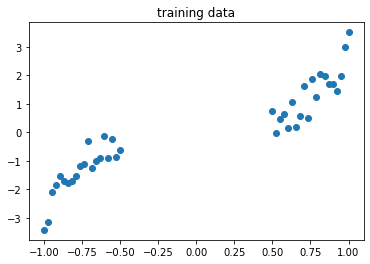

bootstrap: 0
bootstrap: 10
bootstrap: 20
bootstrap: 30
bootstrap: 40
bootstrap: 50
bootstrap: 60
bootstrap: 70
bootstrap: 80
bootstrap: 90


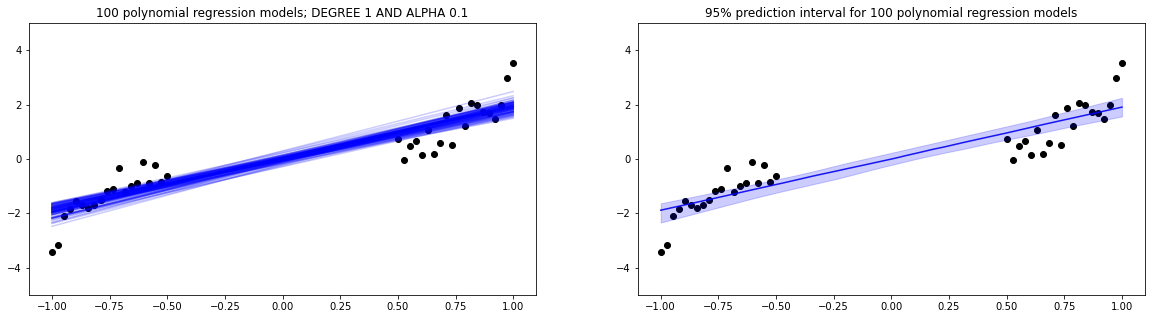

The computed scores or log marginal likehood of this Bayesian Ridge Polynomial Regression Model are: [-86.5596759  -46.05932857 -44.59686571 -44.5966925  -44.59668732]
bootstrap: 0
bootstrap: 10
bootstrap: 20
bootstrap: 30
bootstrap: 40
bootstrap: 50
bootstrap: 60
bootstrap: 70
bootstrap: 80
bootstrap: 90


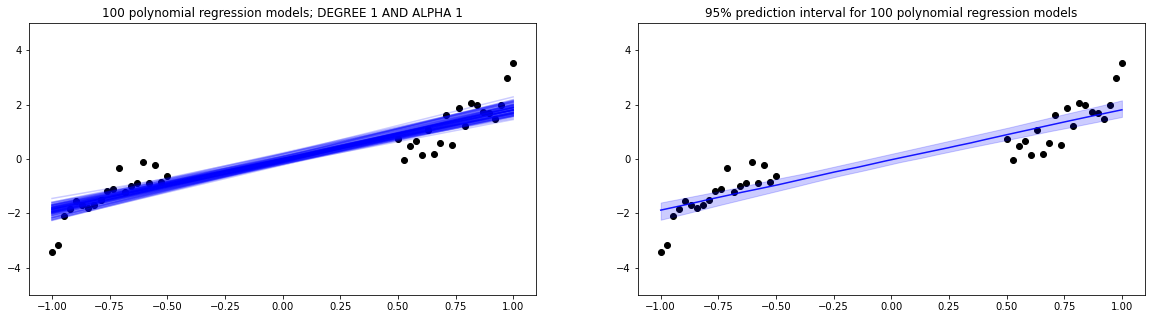

The computed scores or log marginal likehood of this Bayesian Ridge Polynomial Regression Model are: [-47.9378447  -38.49793183 -38.49644974 -38.49643824]
bootstrap: 0
bootstrap: 10
bootstrap: 20
bootstrap: 30
bootstrap: 40
bootstrap: 50
bootstrap: 60
bootstrap: 70
bootstrap: 80
bootstrap: 90


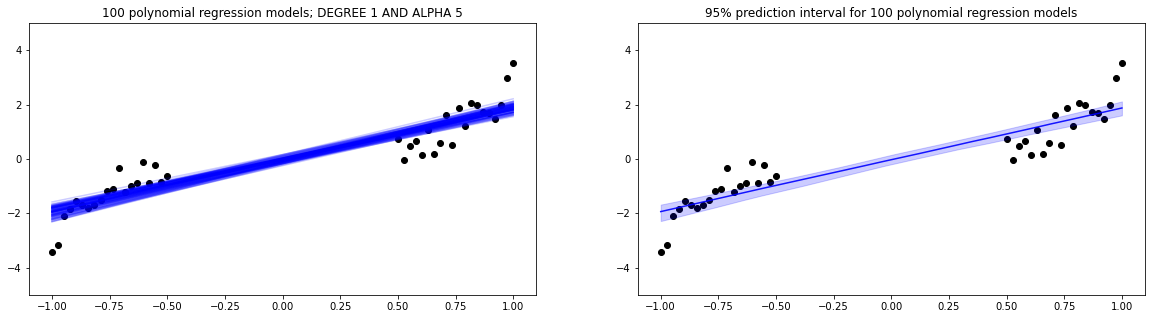

The computed scores or log marginal likehood of this Bayesian Ridge Polynomial Regression Model are: [-59.3608791  -47.51985968 -47.51985951 -47.51985962]
bootstrap: 0
bootstrap: 10
bootstrap: 20
bootstrap: 30
bootstrap: 40
bootstrap: 50
bootstrap: 60
bootstrap: 70
bootstrap: 80
bootstrap: 90


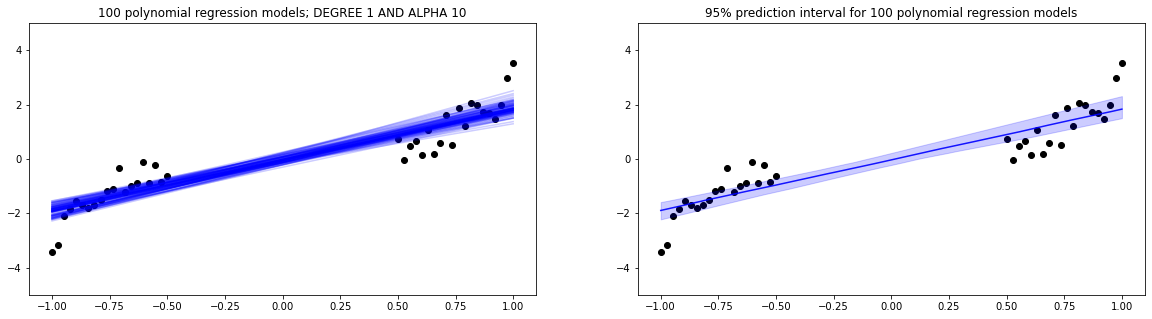

The computed scores or log marginal likehood of this Bayesian Ridge Polynomial Regression Model are: [-82.64279859 -42.05305594 -42.05304836 -42.05304889]
bootstrap: 0
bootstrap: 10
bootstrap: 20
bootstrap: 30
bootstrap: 40
bootstrap: 50
bootstrap: 60
bootstrap: 70
bootstrap: 80
bootstrap: 90


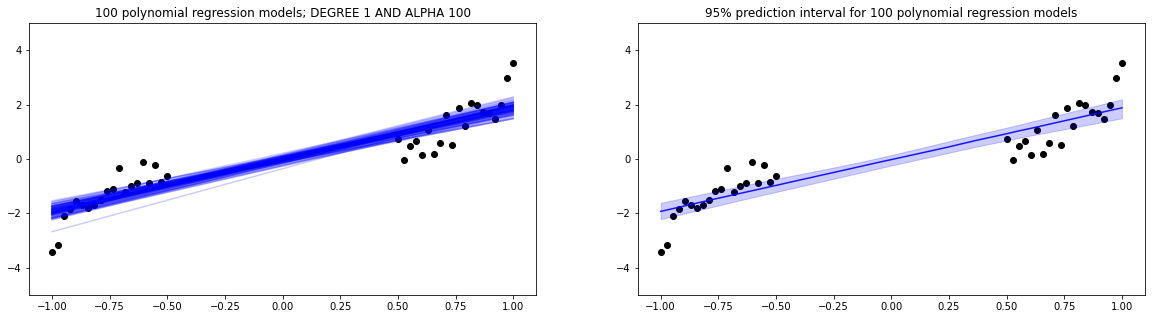

The computed scores or log marginal likehood of this Bayesian Ridge Polynomial Regression Model are: [-112.50147258  191.14974614  191.14974667  191.14974666]
bootstrap: 0
bootstrap: 10
bootstrap: 20
bootstrap: 30
bootstrap: 40
bootstrap: 50
bootstrap: 60
bootstrap: 70
bootstrap: 80
bootstrap: 90


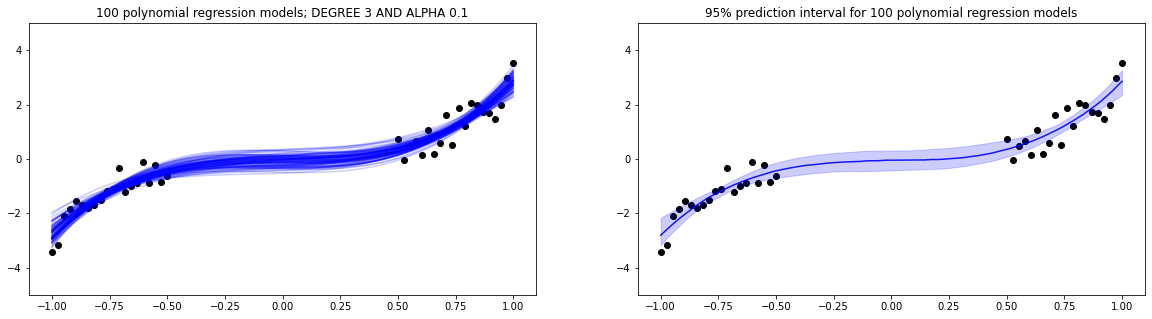

The computed scores or log marginal likehood of this Bayesian Ridge Polynomial Regression Model are: [-86.84554889 -36.00428972 -30.36918698 -30.29471317 -30.29413086
 -30.29412657 -30.29408857]
bootstrap: 0
bootstrap: 10
bootstrap: 20
bootstrap: 30
bootstrap: 40
bootstrap: 50
bootstrap: 60
bootstrap: 70
bootstrap: 80
bootstrap: 90


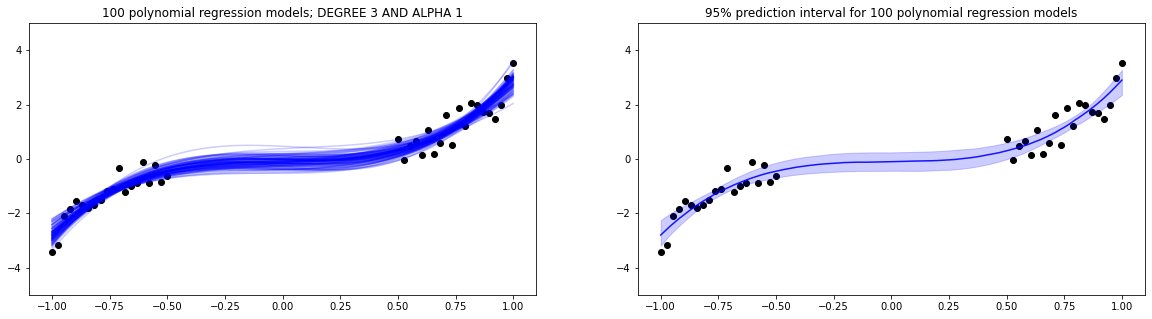

The computed scores or log marginal likehood of this Bayesian Ridge Polynomial Regression Model are: [-45.2385318  -13.23947794 -10.36222743 -10.35409524 -10.35408376
 -10.35407077]
bootstrap: 0
bootstrap: 10
bootstrap: 20
bootstrap: 30
bootstrap: 40
bootstrap: 50
bootstrap: 60
bootstrap: 70
bootstrap: 80
bootstrap: 90


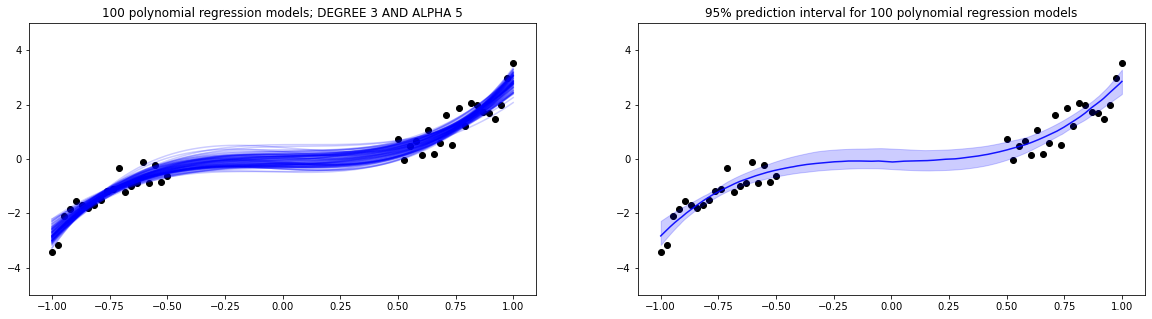

The computed scores or log marginal likehood of this Bayesian Ridge Polynomial Regression Model are: [-22.64925246 -18.2722511  -18.21318627 -18.21303091 -18.2130305
 -18.21302636]
bootstrap: 0
bootstrap: 10
bootstrap: 20
bootstrap: 30
bootstrap: 40
bootstrap: 50
bootstrap: 60
bootstrap: 70
bootstrap: 80
bootstrap: 90


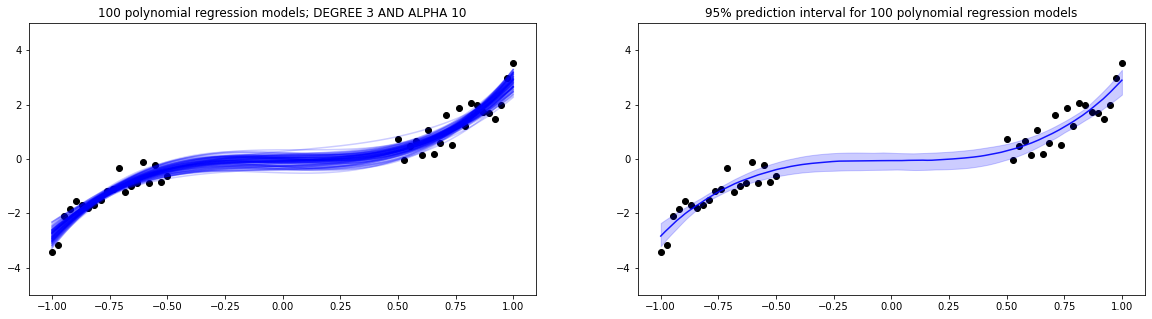

The computed scores or log marginal likehood of this Bayesian Ridge Polynomial Regression Model are: [-10.54949498  -9.37744607  -9.37162058  -9.37160366  -9.37157381]
bootstrap: 0
bootstrap: 10
bootstrap: 20
bootstrap: 30
bootstrap: 40
bootstrap: 50
bootstrap: 60
bootstrap: 70
bootstrap: 80
bootstrap: 90


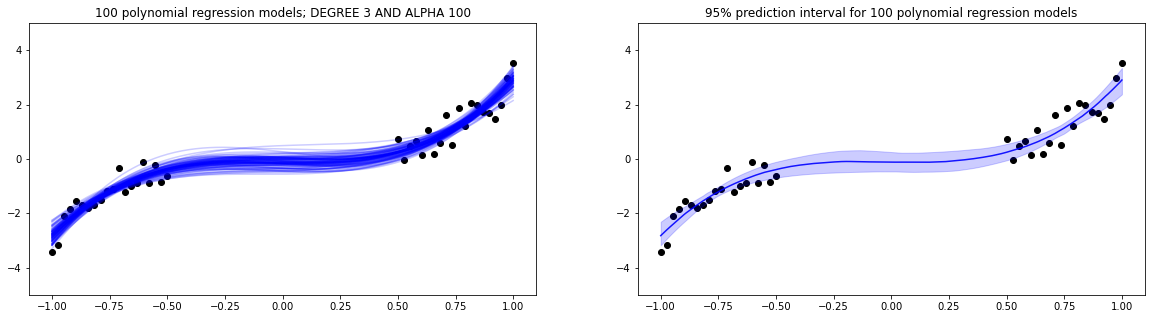

The computed scores or log marginal likehood of this Bayesian Ridge Polynomial Regression Model are: [172.86702315 261.41950971 261.41952129 261.41951945]
bootstrap: 0
bootstrap: 10
bootstrap: 20
bootstrap: 30
bootstrap: 40
bootstrap: 50
bootstrap: 60
bootstrap: 70
bootstrap: 80
bootstrap: 90


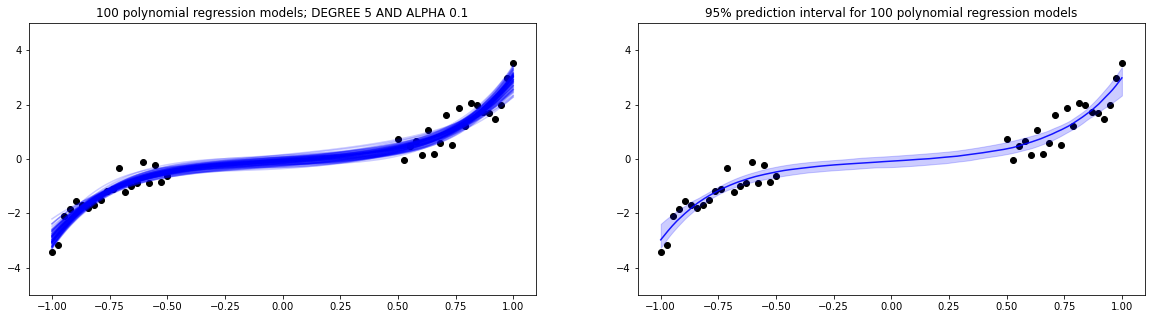

The computed scores or log marginal likehood of this Bayesian Ridge Polynomial Regression Model are: [-86.46070776 -26.7192038  -22.57224491 -22.56633073 -22.56625808
 -22.56625701 -22.56625699 -22.56625086]
bootstrap: 0
bootstrap: 10
bootstrap: 20
bootstrap: 30
bootstrap: 40
bootstrap: 50
bootstrap: 60
bootstrap: 70
bootstrap: 80
bootstrap: 90


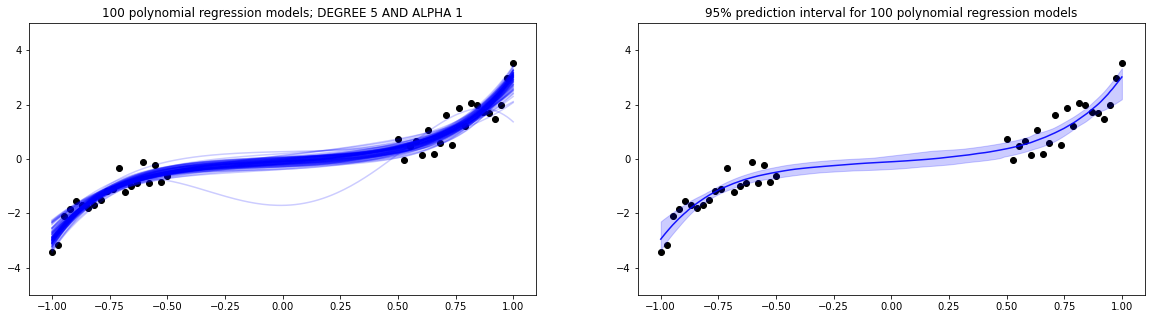

The computed scores or log marginal likehood of this Bayesian Ridge Polynomial Regression Model are: [-45.22210617 -22.13665906 -22.13052882 -22.13052882 -22.13052877]
bootstrap: 0
bootstrap: 10
bootstrap: 20
bootstrap: 30
bootstrap: 40
bootstrap: 50
bootstrap: 60
bootstrap: 70
bootstrap: 80
bootstrap: 90


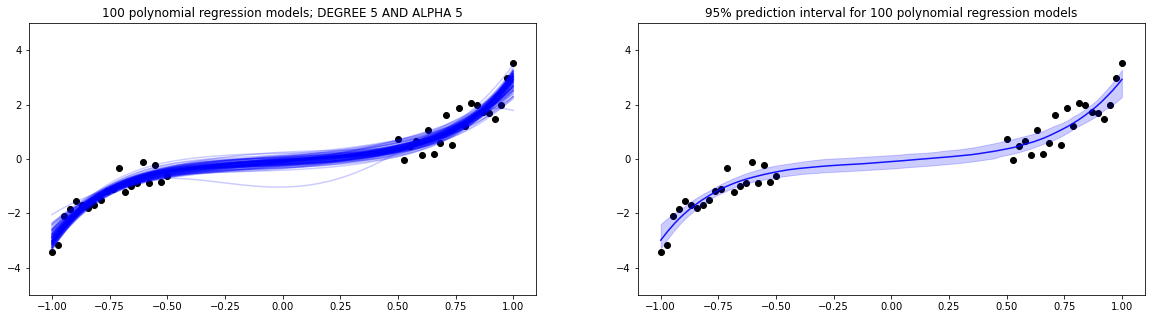

The computed scores or log marginal likehood of this Bayesian Ridge Polynomial Regression Model are: [-16.91734575 -11.86123394 -11.86123332 -11.86123294]
bootstrap: 0
bootstrap: 10
bootstrap: 20
bootstrap: 30
bootstrap: 40
bootstrap: 50
bootstrap: 60
bootstrap: 70
bootstrap: 80
bootstrap: 90


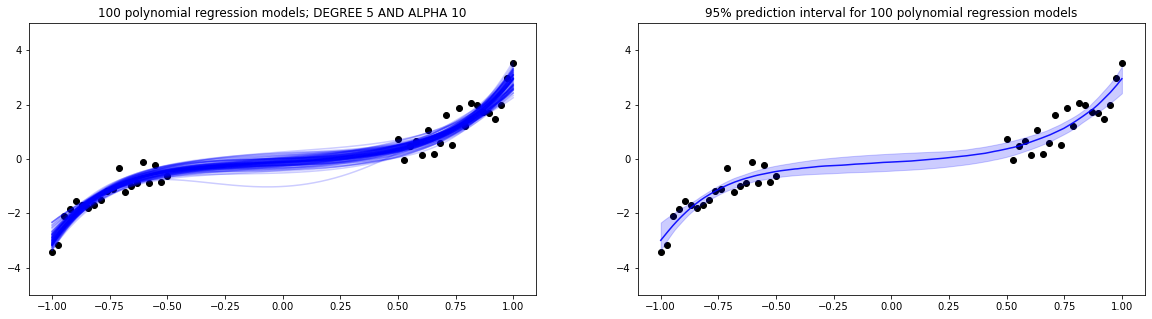

The computed scores or log marginal likehood of this Bayesian Ridge Polynomial Regression Model are: [-9.03803615 -8.89235904 -8.89219974 -8.89219953 -8.89220313]
bootstrap: 0
bootstrap: 10
bootstrap: 20
bootstrap: 30
bootstrap: 40
bootstrap: 50
bootstrap: 60
bootstrap: 70
bootstrap: 80
bootstrap: 90


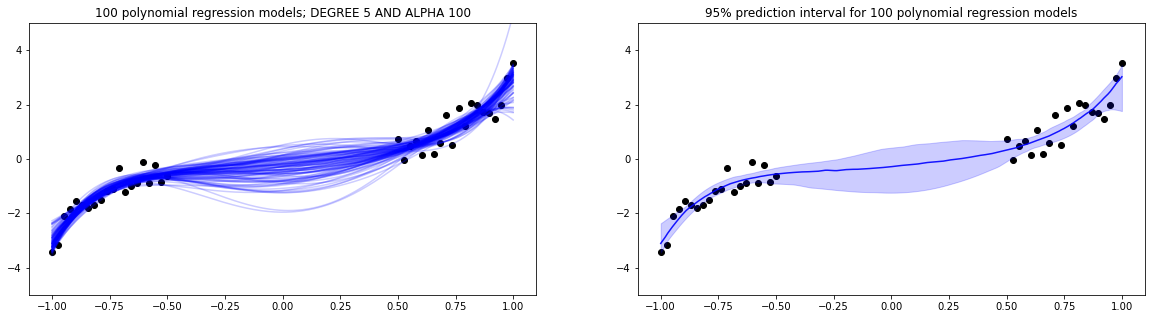

The computed scores or log marginal likehood of this Bayesian Ridge Polynomial Regression Model are: [270.5637798  302.62343493 302.63875458 302.64031599 302.64046642
 302.64048065 302.64048199 302.64048211 302.6405645 ]
bootstrap: 0
bootstrap: 10
bootstrap: 20
bootstrap: 30
bootstrap: 40
bootstrap: 50
bootstrap: 60
bootstrap: 70
bootstrap: 80
bootstrap: 90


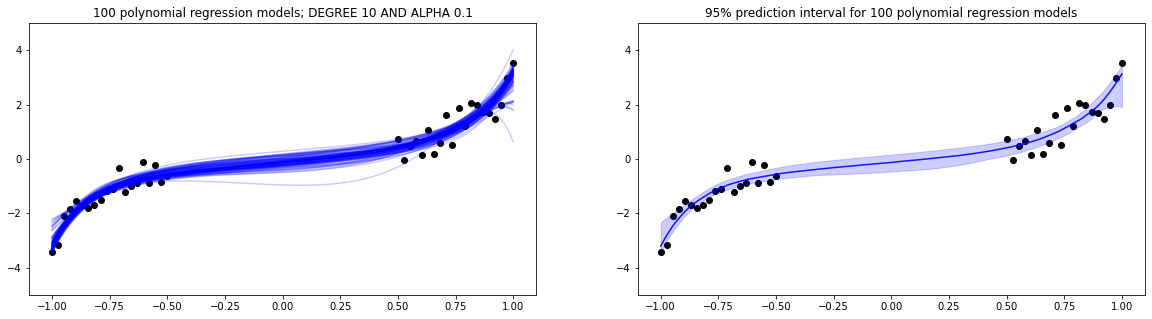

The computed scores or log marginal likehood of this Bayesian Ridge Polynomial Regression Model are: [-86.21880363 -21.38439739 -19.1859356  -19.18574737 -19.18574728
 -19.1857486 ]
bootstrap: 0
bootstrap: 10
bootstrap: 20
bootstrap: 30
bootstrap: 40
bootstrap: 50
bootstrap: 60
bootstrap: 70
bootstrap: 80
bootstrap: 90


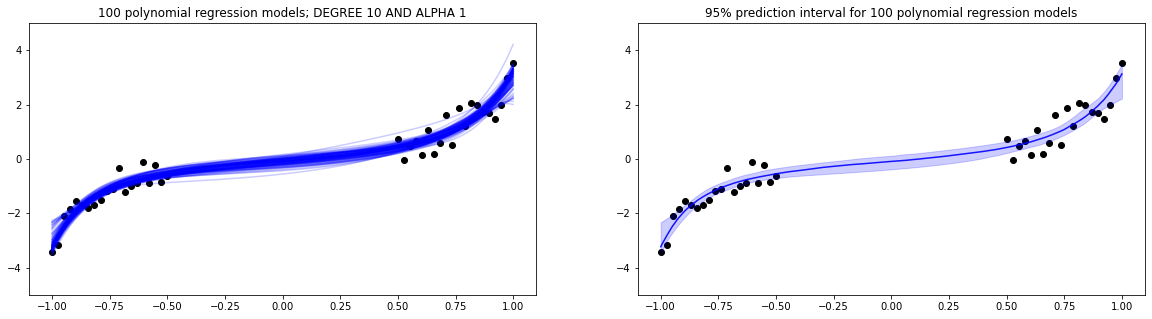

The computed scores or log marginal likehood of this Bayesian Ridge Polynomial Regression Model are: [-45.89701381 -21.87950534 -21.87172012 -21.87171049 -21.87171047
 -21.87170948]
bootstrap: 0
bootstrap: 10
bootstrap: 20
bootstrap: 30
bootstrap: 40
bootstrap: 50
bootstrap: 60
bootstrap: 70
bootstrap: 80
bootstrap: 90


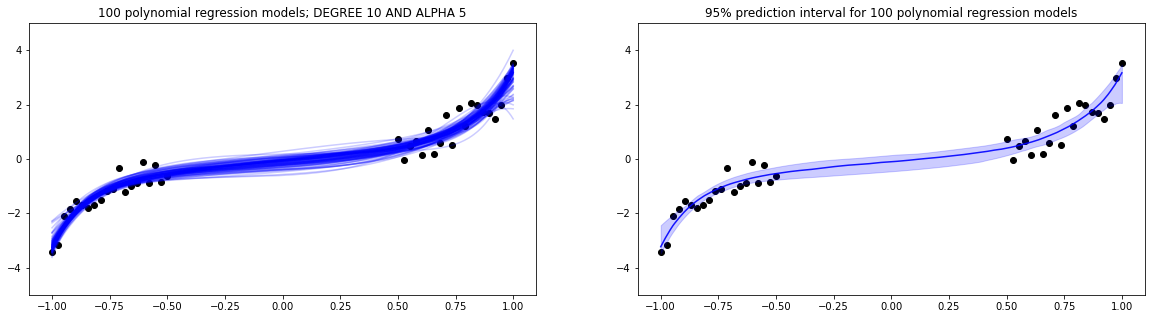

The computed scores or log marginal likehood of this Bayesian Ridge Polynomial Regression Model are: [-16.70821087  -8.38273578  -8.33599507  -8.32988806  -8.32907126
  -8.32896176  -8.32894708  -8.32894511  -8.32894485  -8.32877729]
bootstrap: 0
bootstrap: 10
bootstrap: 20
bootstrap: 30
bootstrap: 40
bootstrap: 50
bootstrap: 60
bootstrap: 70
bootstrap: 80
bootstrap: 90


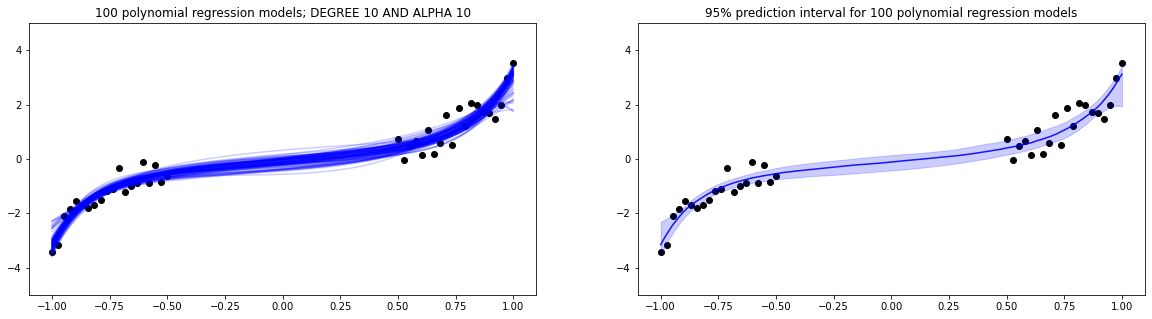

The computed scores or log marginal likehood of this Bayesian Ridge Polynomial Regression Model are: [-6.61430176 -6.26207197 -6.2525008  -6.25212898 -6.25211539 -6.2521149
 -6.25219604]
bootstrap: 0
bootstrap: 10
bootstrap: 20
bootstrap: 30
bootstrap: 40
bootstrap: 50
bootstrap: 60
bootstrap: 70
bootstrap: 80
bootstrap: 90


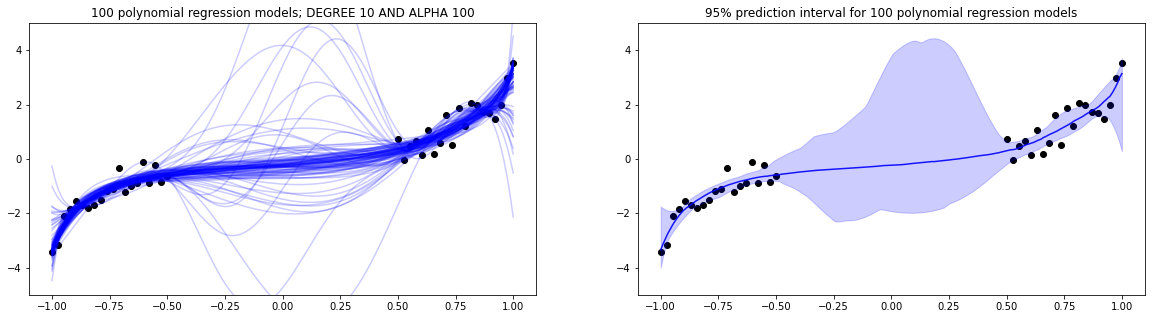

The computed scores or log marginal likehood of this Bayesian Ridge Polynomial Regression Model are: [152.52910977 250.69409259 250.72381814 250.75946641 250.80205171
 250.85205284 250.90866859 250.96892401 251.02731694 251.07710382
 251.11336906 251.13560328 251.14714431 251.15234159 251.15444188
 251.15522906 251.15551001 251.15560729 251.15564036 251.15565148
 251.1556552  251.15565644 251.15565685 251.15565698 251.155393  ]
bootstrap: 0
bootstrap: 10
bootstrap: 20
bootstrap: 30
bootstrap: 40
bootstrap: 50
bootstrap: 60
bootstrap: 70
bootstrap: 80
bootstrap: 90


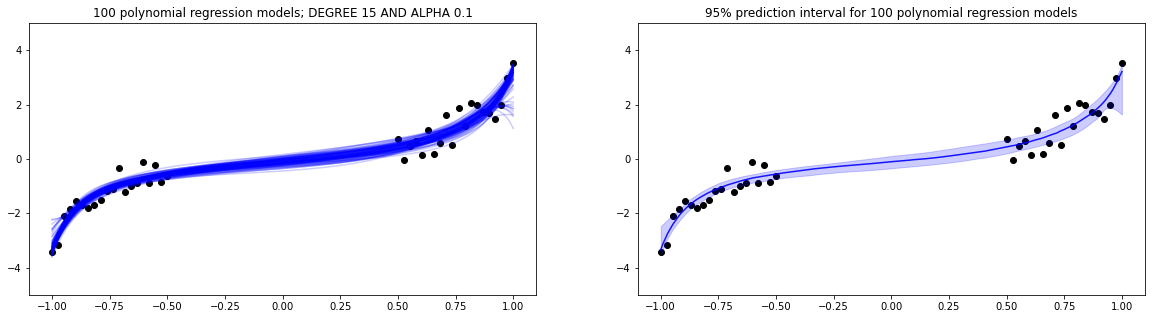

The computed scores or log marginal likehood of this Bayesian Ridge Polynomial Regression Model are: [-86.63157606 -32.90175154 -31.96402093 -31.94491252 -31.94332247
 -31.94318065 -31.94316777 -31.9431666  -31.94316649 -31.94308567]
bootstrap: 0
bootstrap: 10
bootstrap: 20
bootstrap: 30
bootstrap: 40
bootstrap: 50
bootstrap: 60
bootstrap: 70
bootstrap: 80
bootstrap: 90


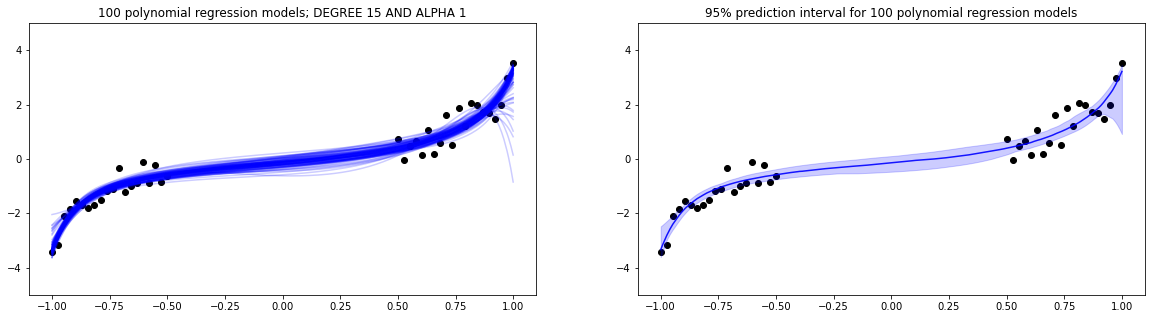

The computed scores or log marginal likehood of this Bayesian Ridge Polynomial Regression Model are: [-47.06435695 -24.00036307 -23.97198607 -23.97143419 -23.97141966
 -23.97141927 -23.97135901]
bootstrap: 0
bootstrap: 10
bootstrap: 20
bootstrap: 30
bootstrap: 40
bootstrap: 50
bootstrap: 60
bootstrap: 70
bootstrap: 80
bootstrap: 90


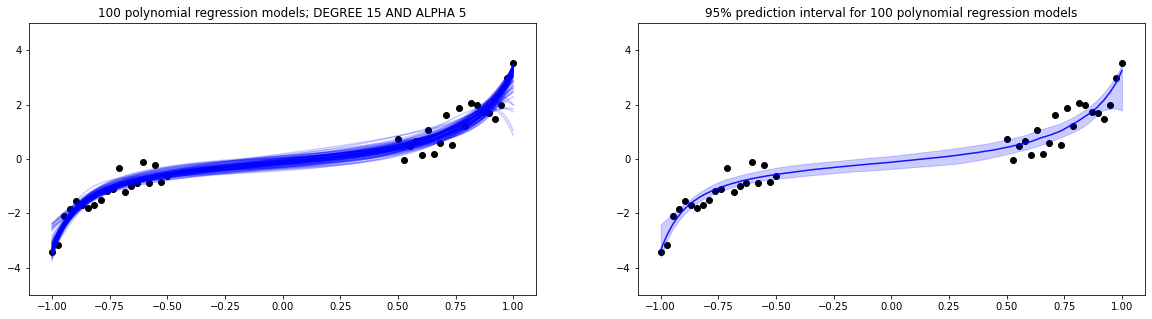

The computed scores or log marginal likehood of this Bayesian Ridge Polynomial Regression Model are: [-25.07678415 -23.48157175 -23.47492495 -23.47463447 -23.47462273
 -23.47462226 -23.47470997]
bootstrap: 0
bootstrap: 10
bootstrap: 20
bootstrap: 30
bootstrap: 40
bootstrap: 50
bootstrap: 60
bootstrap: 70
bootstrap: 80
bootstrap: 90


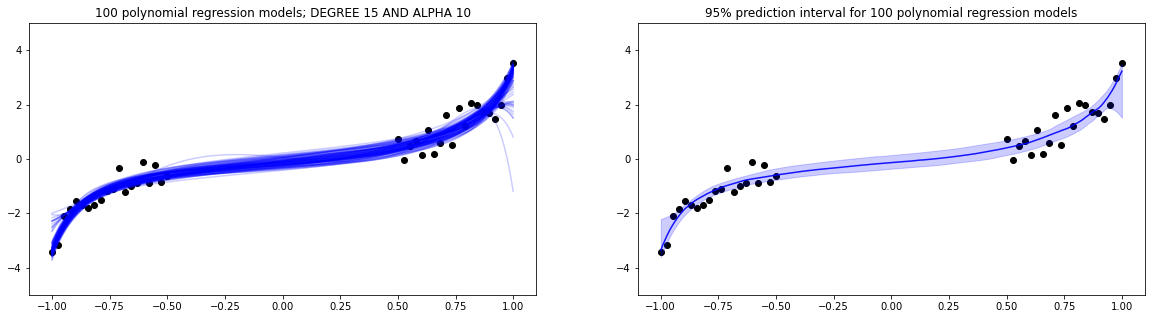

The computed scores or log marginal likehood of this Bayesian Ridge Polynomial Regression Model are: [-13.14621709 -12.72372297 -12.47681447 -12.38389731 -12.36615397
 -12.36402745 -12.36382163 -12.36380315 -12.36380153 -12.36380139
 -12.36389128]
bootstrap: 0
bootstrap: 10
bootstrap: 20
bootstrap: 30
bootstrap: 40
bootstrap: 50
bootstrap: 60
bootstrap: 70
bootstrap: 80
bootstrap: 90


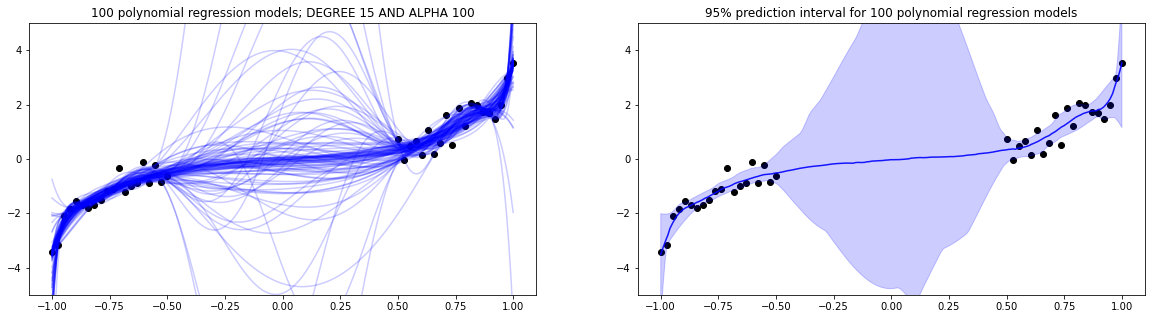

The computed scores or log marginal likehood of this Bayesian Ridge Polynomial Regression Model are: [273.01898319 303.93651182 304.10506442 304.14218072 304.15290279
 304.15646188 304.15773742 304.15821541 304.15839941 304.15847141
 304.15849987 304.15851119 304.15851572 304.15851753 304.15851825
 304.15851855 304.15851866 304.15851871 304.15851873 304.15864415]
bootstrap: 0
bootstrap: 10
bootstrap: 20
bootstrap: 30
bootstrap: 40
bootstrap: 50
bootstrap: 60
bootstrap: 70
bootstrap: 80
bootstrap: 90


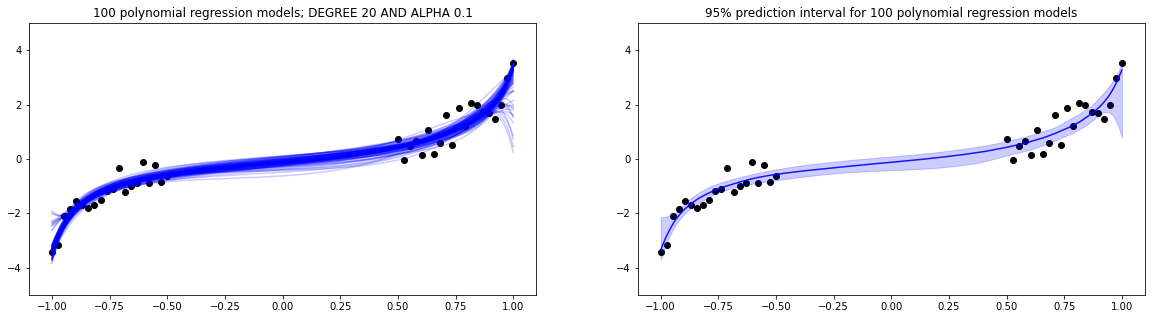

The computed scores or log marginal likehood of this Bayesian Ridge Polynomial Regression Model are: [-86.80925083 -28.91211301 -27.80574597 -27.80309871 -27.80303792
 -27.8030364  -27.80303636 -27.80301774]
bootstrap: 0
bootstrap: 10
bootstrap: 20
bootstrap: 30
bootstrap: 40
bootstrap: 50
bootstrap: 60
bootstrap: 70
bootstrap: 80
bootstrap: 90


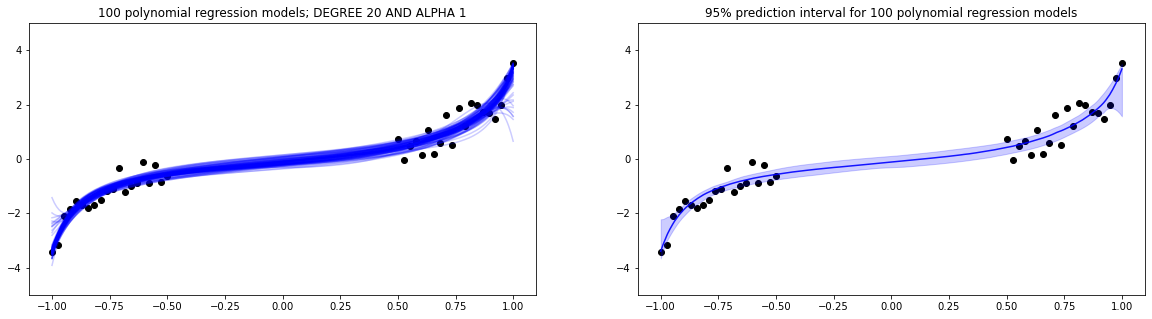

The computed scores or log marginal likehood of this Bayesian Ridge Polynomial Regression Model are: [-47.22865421 -24.93336981 -24.91491841 -24.9145127  -24.91450038
 -24.91449999 -24.91443122]
bootstrap: 0
bootstrap: 10
bootstrap: 20
bootstrap: 30
bootstrap: 40
bootstrap: 50
bootstrap: 60
bootstrap: 70
bootstrap: 80
bootstrap: 90


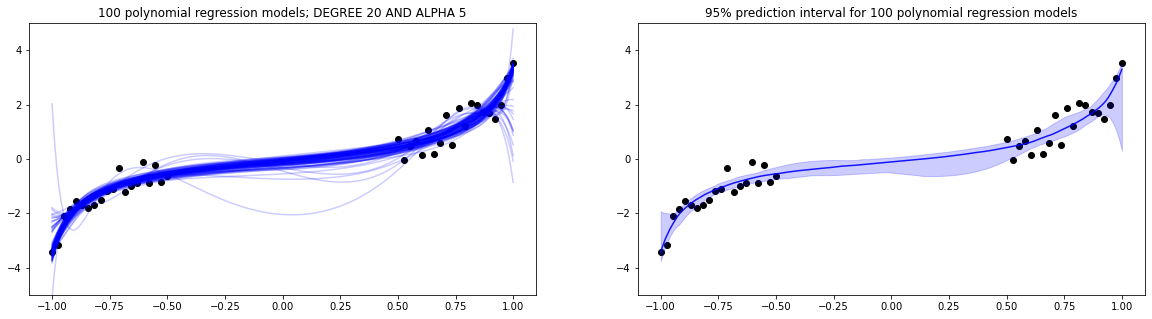

The computed scores or log marginal likehood of this Bayesian Ridge Polynomial Regression Model are: [-23.56649248 -20.66933305 -20.64289283 -20.64229989 -20.64229045
 -20.64229031 -20.6423154 ]
bootstrap: 0
bootstrap: 10
bootstrap: 20
bootstrap: 30
bootstrap: 40
bootstrap: 50
bootstrap: 60
bootstrap: 70
bootstrap: 80
bootstrap: 90


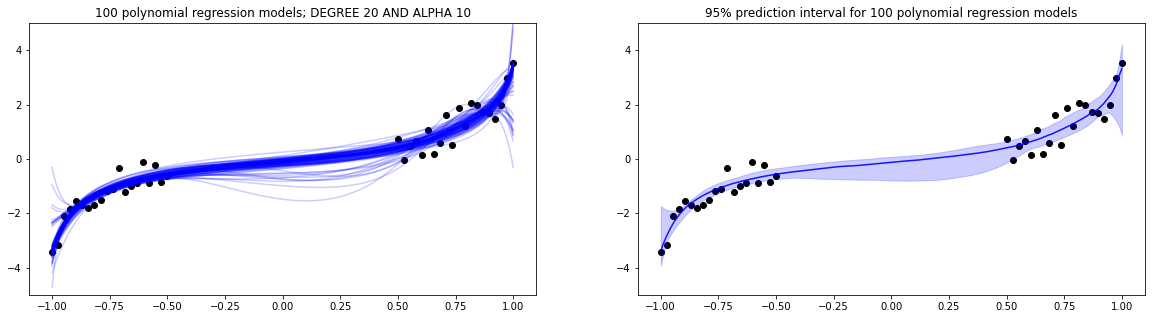

The computed scores or log marginal likehood of this Bayesian Ridge Polynomial Regression Model are: [-14.90634983 -13.3580539  -13.02989674 -13.02132198 -13.0212914
 -13.02129133 -13.02129638]
bootstrap: 0
bootstrap: 10
bootstrap: 20
bootstrap: 30
bootstrap: 40
bootstrap: 50
bootstrap: 60
bootstrap: 70
bootstrap: 80
bootstrap: 90


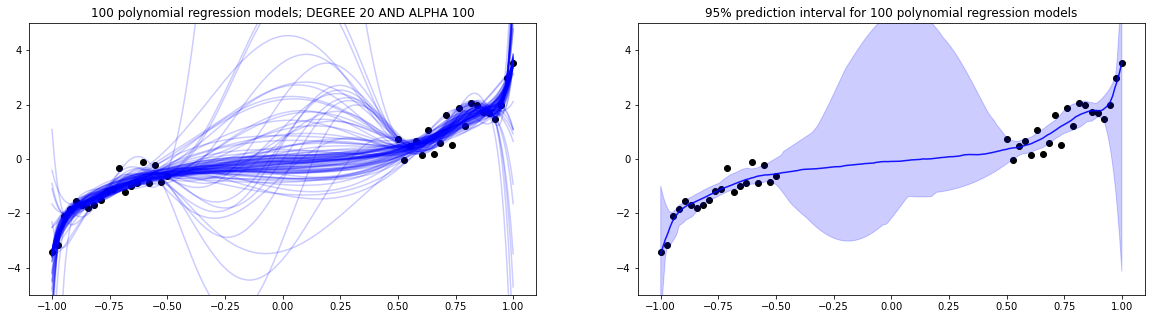

The computed scores or log marginal likehood of this Bayesian Ridge Polynomial Regression Model are: [211.25487754 271.39117526 271.42883634 271.45410392 271.47105891
 271.48245207 271.49011922 271.49528471 271.49876715 271.50111562
 271.50269939 271.50376728 271.50448713 271.50497219 271.50529894
 271.50551897 271.50566708 271.50576676 271.50583382 271.50587893
 271.50590927 271.50592967 271.50594339 271.50595261 271.5059588
 271.50596297 271.50596577 271.50596765 271.50596891 271.50596976
 271.50597034 271.50597072 271.50597098 271.50597115 271.50597127
 271.50597134 271.50556563]
bootstrap: 0
bootstrap: 10
bootstrap: 20
bootstrap: 30
bootstrap: 40
bootstrap: 50
bootstrap: 60
bootstrap: 70
bootstrap: 80
bootstrap: 90


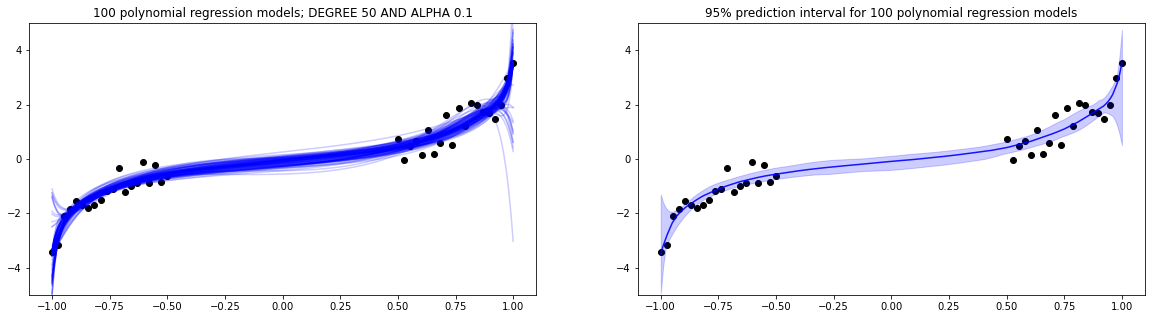

The computed scores or log marginal likehood of this Bayesian Ridge Polynomial Regression Model are: [-87.94278344 -29.72950741 -29.07982975 -29.07974931 -29.07974915
 -29.07974102]
bootstrap: 0
bootstrap: 10
bootstrap: 20
bootstrap: 30
bootstrap: 40
bootstrap: 50
bootstrap: 60
bootstrap: 70
bootstrap: 80
bootstrap: 90


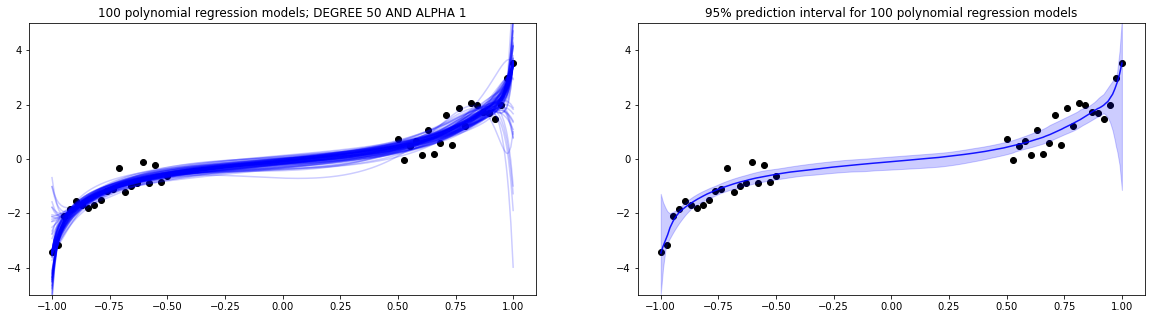

The computed scores or log marginal likehood of this Bayesian Ridge Polynomial Regression Model are: [-48.05417856 -28.06509274 -28.06472788 -28.06472772 -28.06471982]
bootstrap: 0
bootstrap: 10
bootstrap: 20
bootstrap: 30
bootstrap: 40
bootstrap: 50
bootstrap: 60
bootstrap: 70
bootstrap: 80
bootstrap: 90


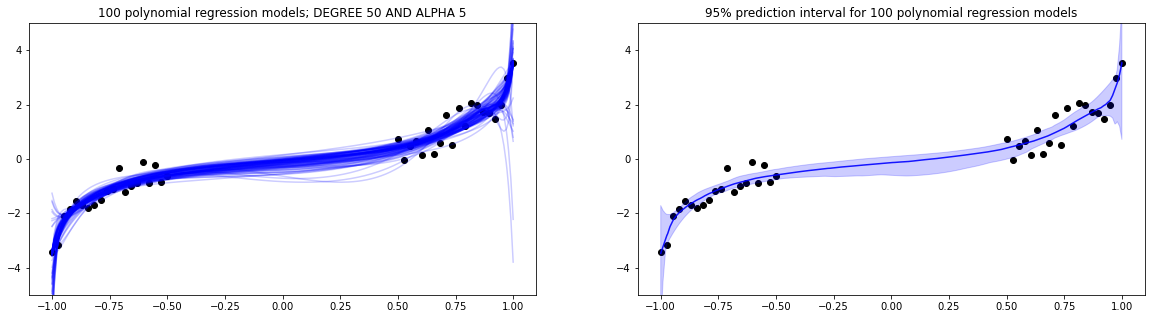

The computed scores or log marginal likehood of this Bayesian Ridge Polynomial Regression Model are: [-23.27523528 -17.78336741 -17.77482494 -17.77441711 -17.77439913
 -17.77439835 -17.77439831 -17.77442782]
bootstrap: 0
bootstrap: 10
bootstrap: 20
bootstrap: 30
bootstrap: 40
bootstrap: 50
bootstrap: 60
bootstrap: 70
bootstrap: 80
bootstrap: 90


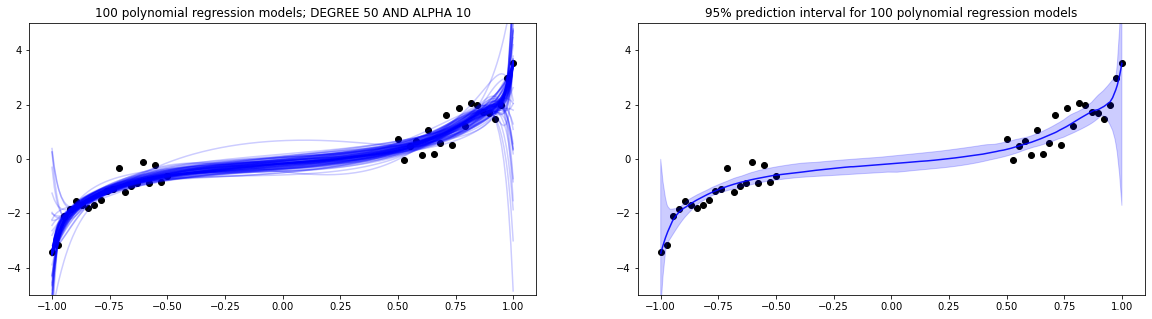

The computed scores or log marginal likehood of this Bayesian Ridge Polynomial Regression Model are: [-5.6329173  -3.74550792 -3.688693   -3.66878841 -3.66258638 -3.66080006
 -3.66030916 -3.66017773 -3.66014303 -3.66013394 -3.66013156 -3.66013094
 -3.66013078 -3.66013074 -3.66026223]
bootstrap: 0
bootstrap: 10
bootstrap: 20
bootstrap: 30
bootstrap: 40
bootstrap: 50
bootstrap: 60
bootstrap: 70
bootstrap: 80
bootstrap: 90


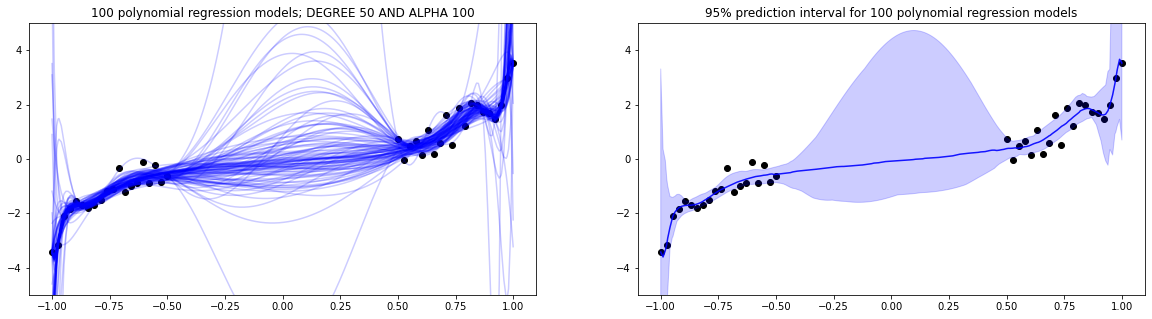

The computed scores or log marginal likehood of this Bayesian Ridge Polynomial Regression Model are: [255.90458081 297.8718856  314.70667024 340.21441269 359.38861018
 372.27548959 377.00443526 377.53456129 377.56420202 377.5656143
 377.56567954 377.56568254 377.56568268 377.56568268 377.56568268
 377.56568268 377.56568336]
bootstrap: 0
bootstrap: 10
bootstrap: 20
bootstrap: 30
bootstrap: 40
bootstrap: 50
bootstrap: 60
bootstrap: 70
bootstrap: 80
bootstrap: 90


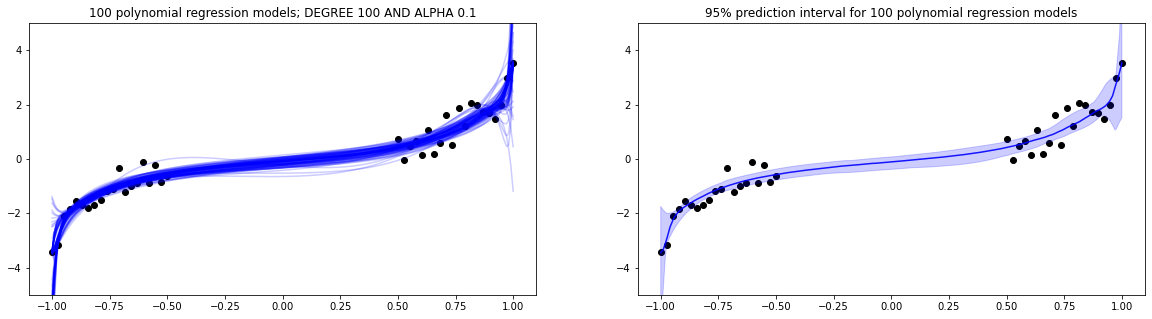

The computed scores or log marginal likehood of this Bayesian Ridge Polynomial Regression Model are: [-87.71670317 -26.12280628 -23.80638327 -23.77968887 -23.77807404
 -23.77796173 -23.77795371 -23.77795314 -23.7779531  -23.7779048 ]
bootstrap: 0
bootstrap: 10
bootstrap: 20
bootstrap: 30
bootstrap: 40
bootstrap: 50
bootstrap: 60
bootstrap: 70
bootstrap: 80
bootstrap: 90


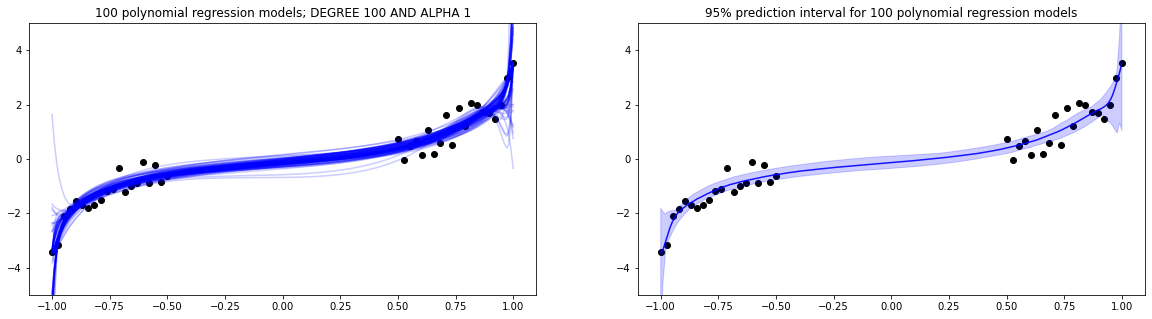

The computed scores or log marginal likehood of this Bayesian Ridge Polynomial Regression Model are: [-48.27405995 -19.80719267 -18.07294433 -17.19811746 -16.8722548
 -16.78963144 -16.7732512  -16.77036724 -16.76988484 -16.76980585
 -16.76979303 -16.76979095 -16.76979062 -16.76979056 -16.76979056
 -16.76975047]
bootstrap: 0
bootstrap: 10
bootstrap: 20
bootstrap: 30
bootstrap: 40
bootstrap: 50
bootstrap: 60
bootstrap: 70
bootstrap: 80
bootstrap: 90


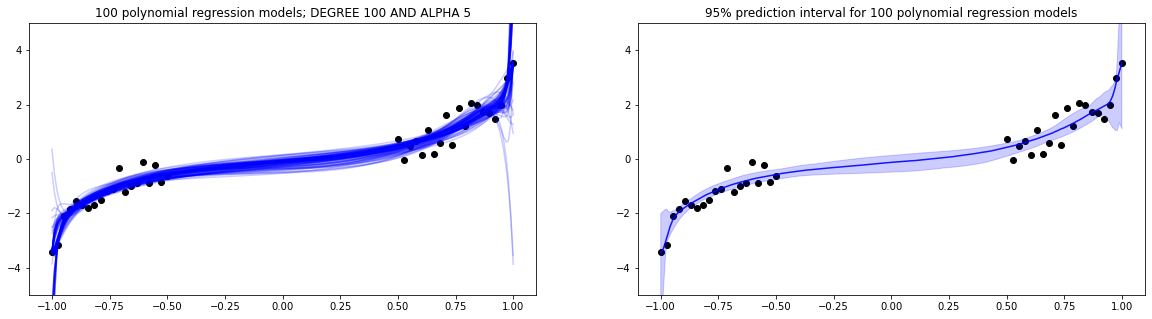

The computed scores or log marginal likehood of this Bayesian Ridge Polynomial Regression Model are: [-20.45994277  -7.11540485  -7.1132585   -7.11312578  -7.11311748
  -7.11311696  -7.11311693  -7.11307777]
bootstrap: 0
bootstrap: 10
bootstrap: 20
bootstrap: 30
bootstrap: 40
bootstrap: 50
bootstrap: 60
bootstrap: 70
bootstrap: 80
bootstrap: 90


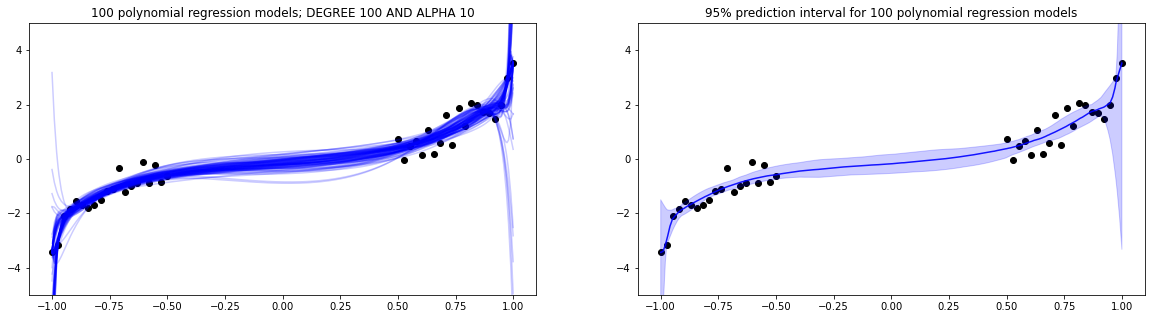

The computed scores or log marginal likehood of this Bayesian Ridge Polynomial Regression Model are: [-10.75318207  -9.83604575  -9.81636005  -9.81038402  -9.80862472
  -9.80811583  -9.80797006  -9.80792853  -9.80791673  -9.80791338
  -9.80791243  -9.80791217  -9.80791209  -9.80811507]
bootstrap: 0
bootstrap: 10
bootstrap: 20
bootstrap: 30
bootstrap: 40
bootstrap: 50
bootstrap: 60
bootstrap: 70
bootstrap: 80
bootstrap: 90


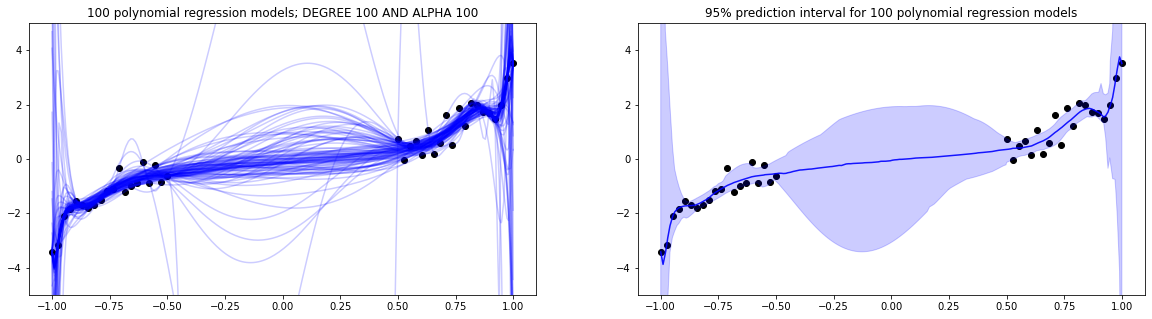

The computed scores or log marginal likehood of this Bayesian Ridge Polynomial Regression Model are: [278.85480761 301.02486897 301.02539938 301.02548817 301.02550306
 301.02550556 301.02550598 301.02550605 301.02550607 301.02556178]


In [15]:
#For 2 and 3
# Number of data points in each of the two segments of the domain
N = 20

# Observation noise variance
noise_variance = 0.3

# Generate toy data
x_train, y_train, x_test, y_test = generate_data(number_of_points=N, noise_variance=noise_variance)

# Plot the training data
plt.scatter(x_train, y_train)
plt.title('training data')
plt.show()

#Define Degrees of interest
D = [1,3,5,10,15,20,50,100]

#Define Alpha of Interest
alpha = [0.1, 1, 5, 10, 100]

for i in D:
    for j in alpha:
        makebayesmodel(i,j)


4. **(Model Selection via Cross-Validation)** For Bayesian kernel regression models we can also perform model selection for $D$ and $\alpha$ using a form of Occam's Razor: select the minimal complexity of model that has the highest average validation log-likelihood. <br><br>
We again select the optimal hyperparameters via cross-validation (by bootstrap):

  1. randomly sample two datasets from the observed data: one for training and one for validation. Fit a Bayesian kernel regression model with some choice of $D$ and $\alpha$ on the training data and evaluate its the log-likelihood of the validation data. Over $S$ number of such randomly sampled pairs of datasets, average the model's validation log-likelihood.
  2. plot the validation score as a function of model complexity, the polynomial degree $d$. 
  3. based on the plot, select the the minimal degree that achieves a high average validation performance (i.e. look for the 'elbow' of the plot).

  Implement model selection for Bayesian polynomial regression by cross-validation for a toy dataset with 400 observations (`number_of_points=200`) and select an optimal degree from $D=[1,3,5,10,15,20,50,100]$, fixing $\alpha=50$. Visualize the 95% posterior predictive interval for the model with the optimal $D$ and $\alpha=50$. Did you select the model with the most desirable predictive uncertainty?
  <br><br>
  **Note:** Model selection of Bayesian models by cross-validation is common practice but it is not perfectly principled. Later in the course we will look at an alternate but less tractable way of performing model selection: by computing the **model evidence**.

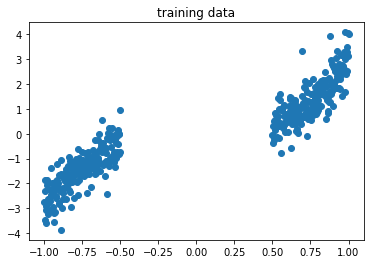

bootstrap: 0
bootstrap: 10
bootstrap: 20
bootstrap: 30
bootstrap: 40
bootstrap: 50
bootstrap: 60
bootstrap: 70
bootstrap: 80
bootstrap: 90


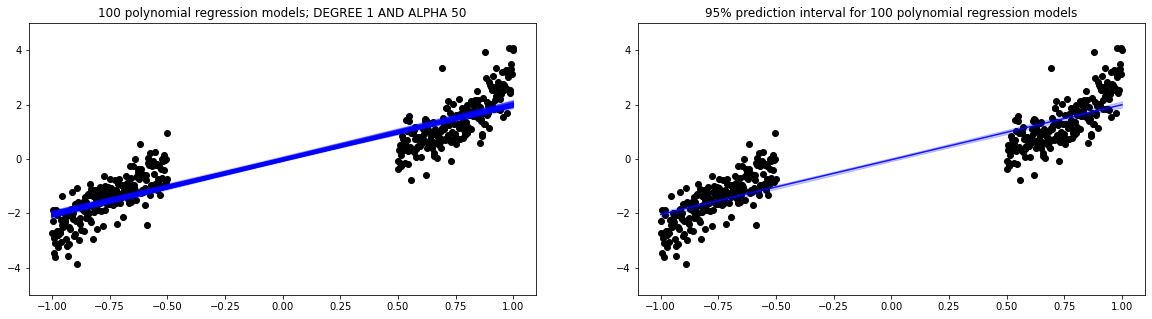

The computed scores or log marginal likehood of this Bayesian Ridge Polynomial Regression Model are: [-4111.86402903  -382.04594346  -382.04594314  -382.04594314]
bootstrap: 0
bootstrap: 10
bootstrap: 20
bootstrap: 30
bootstrap: 40
bootstrap: 50
bootstrap: 60
bootstrap: 70
bootstrap: 80
bootstrap: 90


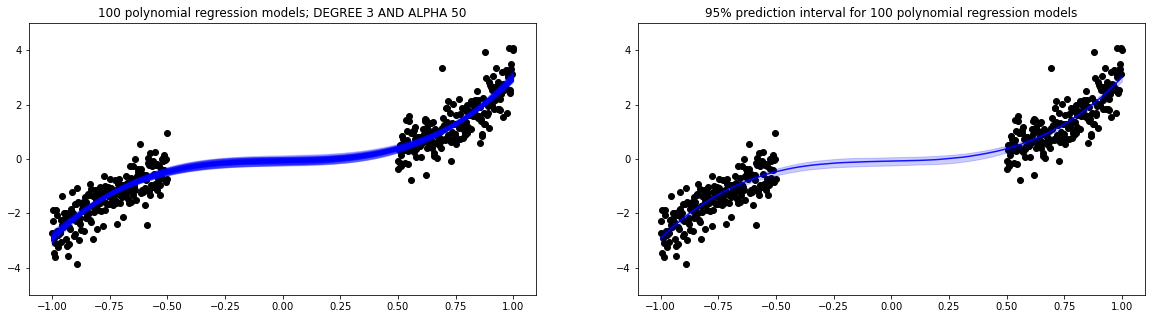

The computed scores or log marginal likehood of this Bayesian Ridge Polynomial Regression Model are: [-1840.97598629  -223.39137532  -223.39129822  -223.39130131]
bootstrap: 0
bootstrap: 10
bootstrap: 20
bootstrap: 30
bootstrap: 40
bootstrap: 50
bootstrap: 60
bootstrap: 70
bootstrap: 80
bootstrap: 90


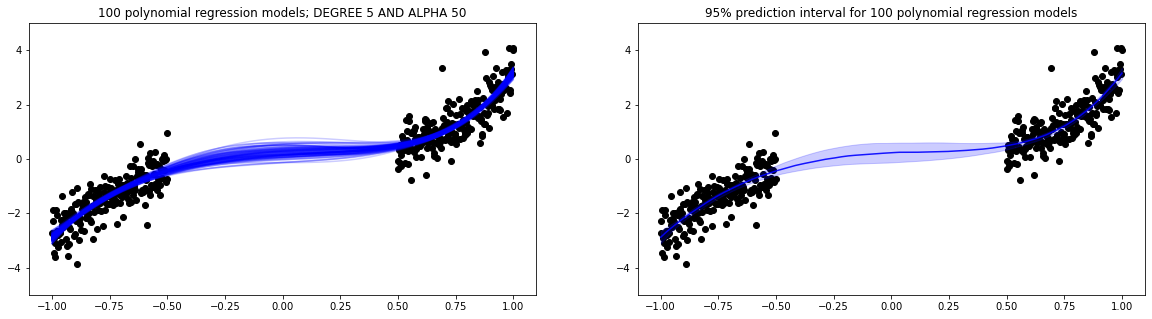

The computed scores or log marginal likehood of this Bayesian Ridge Polynomial Regression Model are: [-2078.75753214  -246.97986988  -246.94062848  -246.94040848
  -246.94040743  -246.94043313]
bootstrap: 0
bootstrap: 10
bootstrap: 20
bootstrap: 30
bootstrap: 40
bootstrap: 50
bootstrap: 60
bootstrap: 70
bootstrap: 80
bootstrap: 90


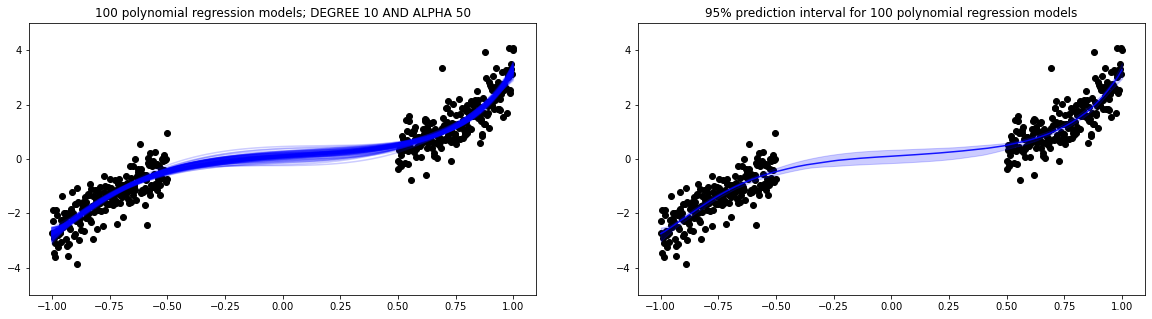

The computed scores or log marginal likehood of this Bayesian Ridge Polynomial Regression Model are: [-1859.45923191  -230.46932768  -228.84505722  -228.60762879
  -228.59706875  -228.59672171  -228.59671087  -228.59671053
  -228.59676725]
bootstrap: 0
bootstrap: 10
bootstrap: 20
bootstrap: 30
bootstrap: 40
bootstrap: 50
bootstrap: 60
bootstrap: 70
bootstrap: 80
bootstrap: 90


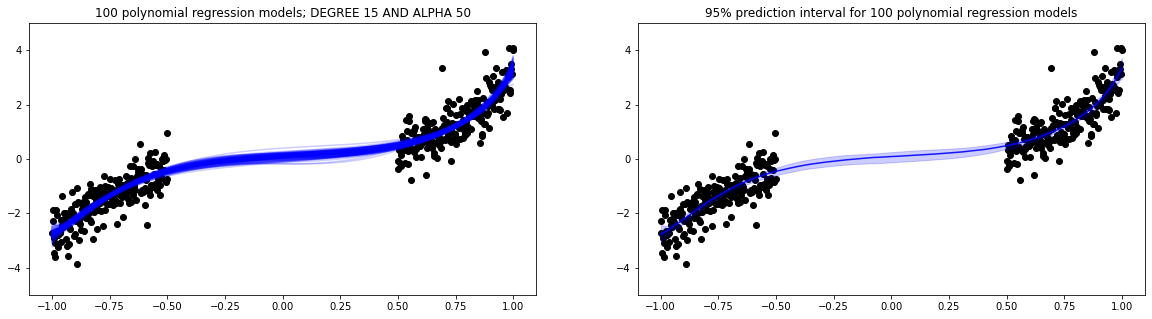

The computed scores or log marginal likehood of this Bayesian Ridge Polynomial Regression Model are: [-2582.10383858  -297.41943302  -296.11480666  -295.69975869
  -295.60215673  -295.58563359  -295.58333686  -295.58304408
  -295.58300796  -295.58300356  -295.58300303  -295.58300296
  -295.58308669]
bootstrap: 0
bootstrap: 10
bootstrap: 20
bootstrap: 30
bootstrap: 40
bootstrap: 50
bootstrap: 60
bootstrap: 70
bootstrap: 80
bootstrap: 90


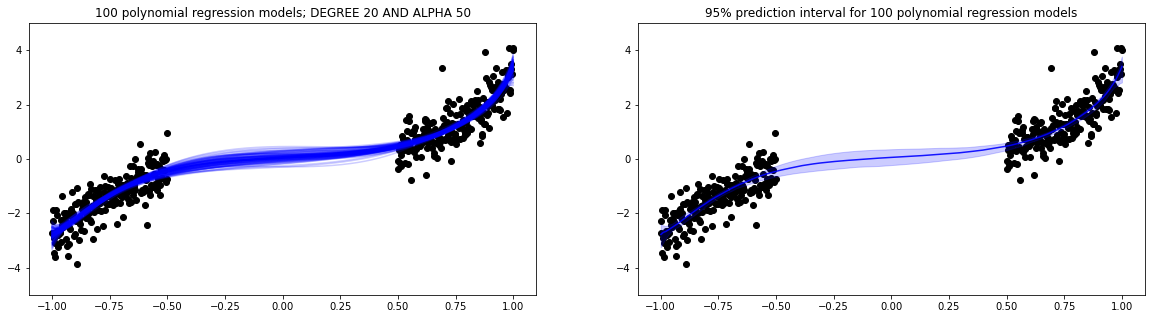

The computed scores or log marginal likehood of this Bayesian Ridge Polynomial Regression Model are: [-1851.06834213  -231.5848644   -230.59720016  -230.4417392
  -230.42187284  -230.4197036   -230.41948203  -230.41945992
  -230.41945773  -230.41945752  -230.4195929 ]
bootstrap: 0
bootstrap: 10
bootstrap: 20
bootstrap: 30
bootstrap: 40
bootstrap: 50
bootstrap: 60
bootstrap: 70
bootstrap: 80
bootstrap: 90


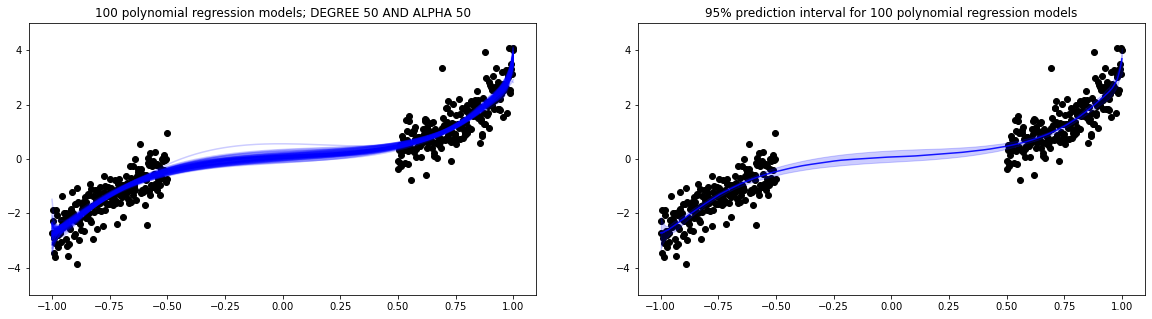

The computed scores or log marginal likehood of this Bayesian Ridge Polynomial Regression Model are: [-2073.72609902  -259.61223454  -257.29278778  -256.66955322
  -256.55813851  -256.54210074  -256.54002477  -256.53976734
  -256.53973592  -256.5397321   -256.53973164  -256.53973158
  -256.53982148]
bootstrap: 0
bootstrap: 10
bootstrap: 20
bootstrap: 30
bootstrap: 40
bootstrap: 50
bootstrap: 60
bootstrap: 70
bootstrap: 80
bootstrap: 90


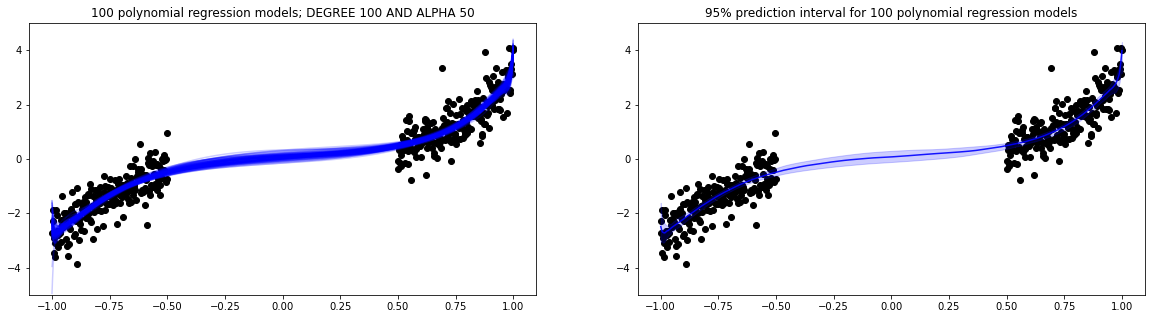

The computed scores or log marginal likehood of this Bayesian Ridge Polynomial Regression Model are: [-2055.07280042  -261.6989997   -258.98553056  -258.44222183
  -258.38059892  -258.37445894  -258.37386516  -258.37380823
  -258.37380278  -258.37380226  -258.37380221  -258.37387758]


In [38]:
#For 2 and 3
# Number of data points in each of the two segments of the domain
N = 200

# Observation noise variance
noise_variance = 0.3

# Generate toy data
x_train, y_train, x_test, y_test = generate_data(number_of_points=N, noise_variance=noise_variance)

# Plot the training data
plt.scatter(x_train, y_train)
plt.title('training data')
plt.show()

#Define Degrees of interest
D = [1,3,5,10,15,20,50,100]

for i in D:
        makebayesmodel(i,50)

## Part III: Comparisons and Conclusions

1. **(Bayesian versus Frequentist Uncertainty)** Compare the types of predictive uncertainties that are generated by Bayesian and ensembles. Characterize the advantages and disadvantages of bootstrap uncertainties from an ensemble. Describe an application where it is better to compute bootstrap uncertainties rather than posterior predictive uncertainties from a Bayesian model (make your assumptions about these applications explicit).
<br><br> 
Characterize the advantages and disadvantages of posterior predictive uncertainties from a Bayesian model. Describe an application where it is better to use these uncertainties rather than bootstrap uncertainties from an ensemble.

***Answer.***

A situation where we have no knowledge of priors or an expectation of the outcome, is where we may be forced to use our traditional thinking of frequentist methods. This would NOT be a situation where we are flipping a coin. Rather more explanatory data analysis may be favored by frequentist views. However, in inference, we may favor Bayesian.

2. **(Measuring Uncertainty)** From your experiments, are any of the model evaluation metrics consdiered in this assignment (MSE, log-likelihood) appropriate for evaluating the quality of predictive uncertainty far away from the training data, that is, if we are concerned about the performance of models under covariate shift should we use these metrics to perform model selection?

***Answer.***

I'm not sure. I would like to experiment with different metrics to select models.